# LendingClub Data Analysis and Model Development

This notebook presents an analysis and machine learning model development for LendingClub loan data as part of the coursework for Carnegie Mellon University – Tepper School of Business.

**Note**: This notebook was inspired by coursework from Professor R. Ravi within the "Business Value Through Integrative Analytics" course, with modifications and extensions made based on my own understanding and analysis.

**Note**: Exploratory Data Analysis (EDA) inspired by Joe Corliss (June 14, 2018)
 
Joe Corlis Notebook Kaggle Link: https://www.kaggle.com/code/pileatedperch/predicting-charge-off-from-initial-listing-data

Reference:
Cohen MC, Guetta CD, Jiao K, Provost F (2018), Data-driven investment strategies for peer-to-peer lending: a case study for teaching data science. *Big Data* 6:3, 191–213.

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans 
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from yellowbrick.target import ClassBalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

# Load debugger, if required
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Import Data

In [2]:
loan_stats_csv_3c = pd.read_csv('LoanStats3c.csv', skiprows=1)
loan_stats_csv_3d = pd.read_csv('LoanStats3d.csv', skiprows=1)
all_data = pd.concat([loan_stats_csv_3c, loan_stats_csv_3d]).reset_index(drop=True)

In [3]:
# Setting default seed
default_seed = 1
output_file = "output_sample_PRACTICE"

# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

# Data Preprocessing

## Identifying columns to keep

From LendingClub Case Study:

"5. Save the resulting data set in a Python ‘‘pickle.’’ For
the sake of this case, restrict yourself to the following
attributes: id, loan_amnt, funded_amnt, term,
int_rate, grade, emp_length, home_ownership,
annual_inc, verification_status, issue_d, loan_status,
purpose, dti, delinq_2yrs, earliest_cr_line, open_acc,
pub_rec, fico_range_high, fico_range_low, revol_-
bal, revol_util, total_pymnt, and recoveries.
Solution: This question introduces the use of
pickles, a useful tool in Python. In a later question,
we discuss the rationale for selecting these
specific attributes."

In [4]:
# Choose columns to keep (Directly from case study)
keep_cols = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 
             'grade', 'emp_length', 'home_ownership', 'annual_inc',
             'verification_status', 'issue_d', 'loan_status',
             'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line',
             'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
             'total_pymnt', 'recoveries', 'last_pymnt_d']

In [5]:
# Subset the dataframe to only keep the above mentioned columns
subset_df = all_data[keep_cols]

In [6]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656728 entries, 0 to 656727
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            656724 non-null  float64
 1   funded_amnt          656724 non-null  float64
 2   term                 656724 non-null  object 
 3   int_rate             656724 non-null  object 
 4   grade                656724 non-null  object 
 5   emp_length           620888 non-null  object 
 6   home_ownership       656724 non-null  object 
 7   annual_inc           656724 non-null  float64
 8   verification_status  656724 non-null  object 
 9   issue_d              656724 non-null  object 
 10  loan_status          656724 non-null  object 
 11  purpose              656724 non-null  object 
 12  dti                  656722 non-null  float64
 13  delinq_2yrs          656724 non-null  float64
 14  earliest_cr_line     656724 non-null  object 
 15  open_acc         

## Drop/Impute Missing Values

### Drop Missing Values Less Than 0.001%

In [7]:
# Create a dataframe showing all null values in the subset_df
subset_df_null = pd.DataFrame(
    {'Count':subset_df.isnull().sum(),
     'Total_Loans':len(subset_df),
     'Percent_Null':100 * subset_df.isnull().sum() / len(subset_df)}
)

# Subset the subset_df_null dataframe to only see columns that 
# contain null values
subset_df_null[subset_df_null['Count'] > 0]

,Count,Total_Loans,Percent_Null
loan_amnt,4,656728,0.000609
funded_amnt,4,656728,0.000609
term,4,656728,0.000609
int_rate,4,656728,0.000609
grade,4,656728,0.000609
emp_length,35840,656728,5.457358
home_ownership,4,656728,0.000609
annual_inc,4,656728,0.000609
verification_status,4,656728,0.000609
issue_d,4,656728,0.000609


In [8]:
# Drop Missing values from features that are less than 
# 0.001%
subset_df_null_small_pct = subset_df_null[subset_df_null['Percent_Null'] < 0.001]

# Drop the missing values from the features in the above
# dataset
subset_df.dropna(subset=subset_df_null_small_pct.index, inplace=True)

In [9]:
# Create a dataframe showing all null values in the subset_df
subset_df_null = pd.DataFrame(
    {'Count':subset_df.isnull().sum(),
     'Total_Loans':len(subset_df),
     'Percent_Null':100 * subset_df.isnull().sum() / len(subset_df)}
)

# Subset the subset_df_null dataframe to only see columns that 
# contain null values
subset_df_null[subset_df_null['Count'] > 0]

,Count,Total_Loans,Percent_Null
emp_length,35834,656722,5.456495
revol_util,287,656722,0.043702
last_pymnt_d,437,656722,0.066543


### Impute Missing Values for Employment Length

In [10]:
subset_df['emp_length'].value_counts(dropna=False)

emp_length
10+ years    221026
2 years       57984
< 1 year      52322
3 years       51697
1 year        42066
4 years       38034
5 years       37981
NaN           35834
8 years       33413
7 years       31513
6 years       28659
9 years       26193
Name: count, dtype: int64

Due to the sheer amount of 10+ years of employment length within this dataset, we do not want to distort or bias the dataset more by imputing missing values as the mode (10+ years). 

Instead, we will take the "Random Imputation Based on Distribution" approach. Put simply, this means that we will allocate the missing values in a way that mirrors the current employment length distribution. For example, if 33.6% of non-missing values are "10+ years", 33.6% of the missing values would be imputed as "10+ years," 8.8% as "2 years," and so on. 

In [11]:
# Get the value counts for non-null emp_length
emp_length_dist = subset_df['emp_length'].value_counts(normalize=True)
emp_length_dist

emp_length
10+ years    0.355984
2 years      0.093389
< 1 year     0.084270
3 years      0.083263
1 year       0.067751
4 years      0.061257
5 years      0.061172
8 years      0.053815
7 years      0.050755
6 years      0.046158
9 years      0.042186
Name: proportion, dtype: float64

In [12]:
# Sample missing values based on the existing distribution
missing_emp_length_count = subset_df['emp_length'].isnull().sum()
missing_emp_length_count

35834

In [13]:
# Sample missing values based on the existing distribution
imputed_values = np.random.choice(emp_length_dist.index, size=missing_emp_length_count, p=emp_length_dist.values)
imputed_values

array(['< 1 year', '2 years', '< 1 year', ..., '8 years', '10+ years',
       '6 years'], dtype=object)

In [14]:
# Fill missing values with the sampled data
subset_df.loc[subset_df['emp_length'].isnull(), 'emp_length'] = imputed_values

In [15]:
# Validate how the distribution of emp_length is after imputation
emp_length_dist = subset_df['emp_length'].value_counts(normalize=True)
emp_length_dist

emp_length
10+ years    0.355863
2 years      0.093285
< 1 year     0.084160
3 years      0.083312
1 year       0.067759
4 years      0.061253
5 years      0.061250
8 years      0.053858
7 years      0.050758
6 years      0.046224
9 years      0.042278
Name: proportion, dtype: float64

In [16]:
# Create a dataframe showing all null values in the subset_df
subset_df_null = pd.DataFrame(
    {'Count':subset_df.isnull().sum(),
     'Total_Loans':len(subset_df),
     'Percent_Null':100 * subset_df.isnull().sum() / len(subset_df)}
)

# Subset the subset_df_null dataframe to only see columns that 
# contain null values
subset_df_null[subset_df_null['Count'] > 0]

,Count,Total_Loans,Percent_Null
revol_util,287,656722,0.043702
last_pymnt_d,437,656722,0.066543


### Impute Missing Values for Revolving Credit Utilization

Since the revol_util feature's missing values only account for approximately 0.04% of the entire dataset and this is a continuous variable, we can simply impute the median. This will align the missing values with the central tendency of the distribution of the feature. The median is used as this dampens the effect of outliers in the dataset and will provide a more unbiased approach to imputation.

In [17]:
# We need to convert the revol_util feature into a percent 
# data type to perform imputation.

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.rstrip()[:-1])
    
subset_df['revol_util'] = subset_df['revol_util'].apply(clean_perc)

In [18]:
# Impute missing values with the median of this feature
subset_df.loc[subset_df['revol_util'].isnull(), 'revol_util'] = subset_df['revol_util'].median()

In [19]:
# Create a dataframe showing all null values in the subset_df
subset_df_null = pd.DataFrame(
    {'Count':subset_df.isnull().sum(),
     'Total_Loans':len(subset_df),
     'Percent_Null':100 * subset_df.isnull().sum() / len(subset_df)}
)

# Subset the subset_df_null dataframe to only see columns that 
# contain null values
subset_df_null[subset_df_null['Count'] > 0]

,Count,Total_Loans,Percent_Null
last_pymnt_d,437,656722,0.066543


### Drop Missing Values for last_pymnt_d

In [20]:
subset_df.dropna(inplace=True)

In [21]:
subset_df.isna().sum()

loan_amnt              0
funded_amnt            0
term                   0
int_rate               0
grade                  0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
issue_d                0
loan_status            0
purpose                0
dti                    0
delinq_2yrs            0
earliest_cr_line       0
open_acc               0
pub_rec                0
revol_bal              0
revol_util             0
total_pymnt            0
recoveries             0
last_pymnt_d           0
dtype: int64

In [22]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 656285 entries, 0 to 656725
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            656285 non-null  float64
 1   funded_amnt          656285 non-null  float64
 2   term                 656285 non-null  object 
 3   int_rate             656285 non-null  object 
 4   grade                656285 non-null  object 
 5   emp_length           656285 non-null  object 
 6   home_ownership       656285 non-null  object 
 7   annual_inc           656285 non-null  float64
 8   verification_status  656285 non-null  object 
 9   issue_d              656285 non-null  object 
 10  loan_status          656285 non-null  object 
 11  purpose              656285 non-null  object 
 12  dti                  656285 non-null  float64
 13  delinq_2yrs          656285 non-null  float64
 14  earliest_cr_line     656285 non-null  object 
 15  open_acc             6

Now, all of the missing data within subset_df has been removed/imputed. 

## Feature Engineering

We'll inspect each feature individually, and do the following:

Drop the feature if it is not useful for predicting the loan status.
View summary statistics and visualize the data, plotting against the loan status.
Modify the feature to make it useful for modeling, if necessary.

The plot_var function was created by Joe Corliss (June 14, 2018)
 
Kaggle Link: https://www.kaggle.com/code/pileatedperch/predicting-charge-off-from-initial-listing-data

In [23]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(subset_df.loc[subset_df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(subset_df[col_name], order=sorted(subset_df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=subset_df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = subset_df.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

### 3.1 loan_amnt

Data Dictionary:
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [24]:
subset_df['loan_amnt'].describe()

count    656285.000000
mean      15108.176478
std        8525.138586
min        1000.000000
25%        8450.000000
50%       13775.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

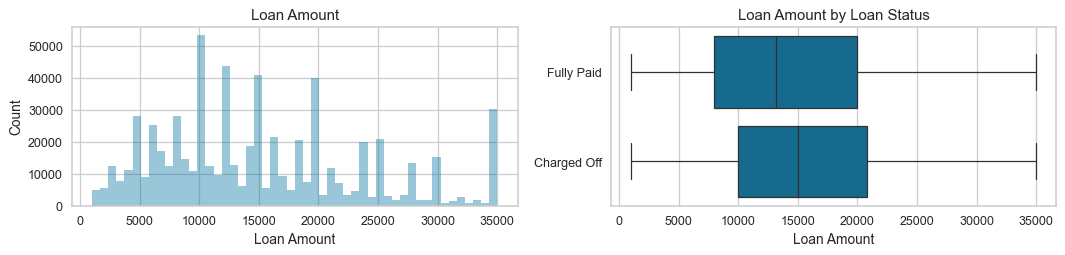

In [25]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Charged Off loans tend to have higher loan amounts.

In [26]:
subset_df.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,121610.0,15846.672971,8407.170658,1000.0,10000.0,15000.0,20800.0,35000.0
Fully Paid,534675.0,14940.207977,8542.843829,1000.0,8000.0,13175.0,20000.0,35000.0


### 3.2 funded_amnt

Data Dictionary: The total amount committed to that loan at that point in time.

In [27]:
subset_df['funded_amnt'].describe()

count    656285.000000
mean      15108.176478
std        8525.138586
min        1000.000000
25%        8450.000000
50%       13775.000000
75%       20000.000000
max       35000.000000
Name: funded_amnt, dtype: float64

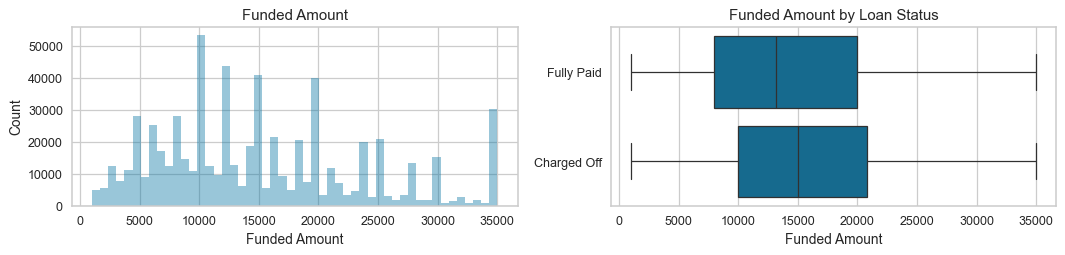

In [28]:
plot_var('funded_amnt', 'Funded Amount', continuous=True)

The funded_amnt feature appears to be right in line with the loan amount and therefore can be dropped from this dataset.  We will drop this later on because we still need this variable. 

### 3.3 term

Data Dictionary: The number of payments on the loan. Values are in months and can be either 36 or 60.

In [29]:
subset_df['term'].value_counts(dropna=False)

term
 36 months    445448
 60 months    210837
Name: count, dtype: int64

In [30]:
# We need to convert these terms into integers for 
# further evaluation
subset_df['term'] = subset_df['term'].apply(lambda s: np.int8(s.split()[0]))

In [31]:
subset_df['term'].value_counts(normalize=True)

term
36    0.678742
60    0.321258
Name: proportion, dtype: float64

In [32]:
subset_df.groupby('term')['loan_status'].value_counts(normalize=True)

term  loan_status
36    Fully Paid     0.855878
      Charged Off    0.144122
60    Fully Paid     0.727700
      Charged Off    0.272300
Name: proportion, dtype: float64

Loans with longer periods (60 months) are almost twice as likely to default than shorter term loans.

### 3.4 int_rate

Data Dictionary: Interest Rate on the loan.

In [33]:
subset_df['int_rate'].describe()

count      656285
unique        151
top        10.99%
freq        30453
Name: int_rate, dtype: object

In [34]:
# We need to convert the int_rate variable to percent
subset_df['int_rate'] = subset_df['int_rate'].apply(clean_perc)

In [35]:
subset_df['int_rate'].describe()

count    656285.000000
mean         13.016728
std           4.356579
min           5.320000
25%           9.670000
50%          12.690000
75%          15.610000
max          28.990000
Name: int_rate, dtype: float64

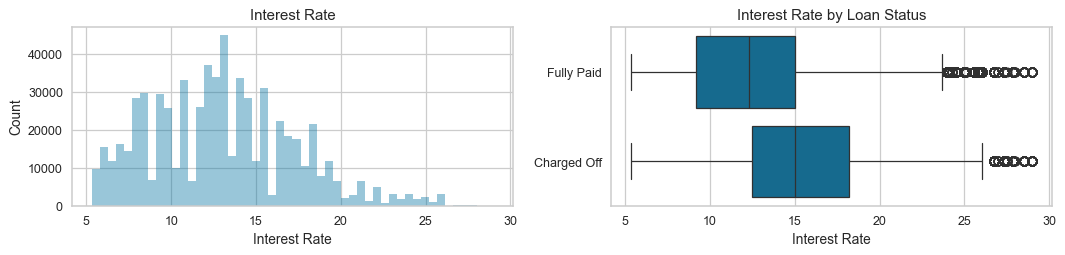

In [36]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged Off loans tend to have higher interest rates which makes sense because payments would naturally be higher. 

In [37]:
subset_df.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,121610.0,15.315544,4.314500,5.32,12.49,14.99,18.20,28.99
Fully Paid,534675.0,12.493870,4.193741,5.32,9.17,12.29,14.99,28.99


### 3.5 grade

Data Dictionary: LC assigned loan grade.

In [38]:
subset_df['grade'].value_counts(dropna=False)

grade
C    187034
B    179480
A    109428
D    105525
E     54979
F     16001
G      3838
Name: count, dtype: int64

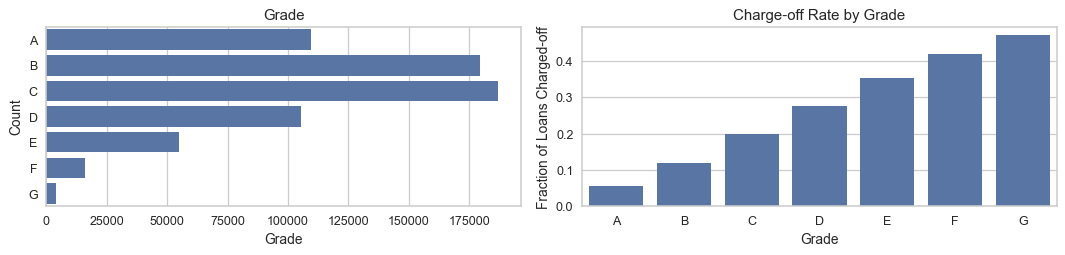

In [39]:
plot_var('grade', 'Grade', continuous=False)

As the grades progress from A to B to C, charge offs become more frequent. This means that LendingClub's grading scale tends to be pretty accurate in rating the risk of charging off loans. 

In [40]:
subset_df.groupby('loan_status')['grade'].describe()

,count,unique,top,freq
loan_status,,,,
Charged Off,121610,7,C,37205
Fully Paid,534675,7,B,158045


### 3.6 emp_length

Data Dictionary: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

In [41]:
subset_df['emp_length'].value_counts(dropna=False)

emp_length
10+ years    233573
2 years       61224
< 1 year      55226
3 years       54675
1 year        44476
4 years       40196
5 years       40187
8 years       35344
7 years       33306
6 years       30334
9 years       27744
Name: count, dtype: int64

In [42]:
# Convert the employment lengths into integer values
subset_df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
subset_df['emp_length'].replace(to_replace='< 1 year', value='0 years', inplace=True)
subset_df['emp_length'] = subset_df['emp_length'].apply(lambda x: np.int8(x.split()[0]))

In [43]:
subset_df['emp_length'].value_counts().sort_index()

emp_length
0      55226
1      44476
2      61224
3      54675
4      40196
5      40187
6      30334
7      33306
8      35344
9      27744
10    233573
Name: count, dtype: int64

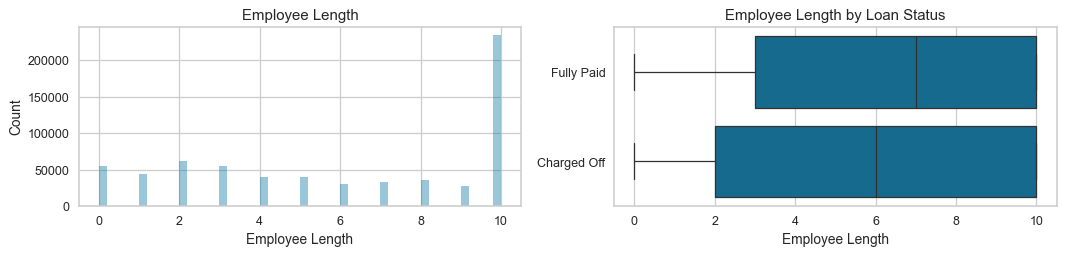

In [44]:
plot_var('emp_length', 'Employee Length', continuous=True)

Borrowers with shorter employment histories tend to default more than those with longer employment histories. 

### 3.7 home_ownership

Data Dictionary: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

In [45]:
subset_df['home_ownership'].value_counts()

home_ownership
MORTGAGE    327459
RENT        260115
OWN          68708
ANY              3
Name: count, dtype: int64

In [46]:
# We will remove ANY as this is too small of a distribution 
# within this feature to work with
subset_df = subset_df[subset_df['home_ownership'] != 'ANY']

In [47]:
subset_df['home_ownership'].value_counts()

home_ownership
MORTGAGE    327459
RENT        260115
OWN          68708
Name: count, dtype: int64

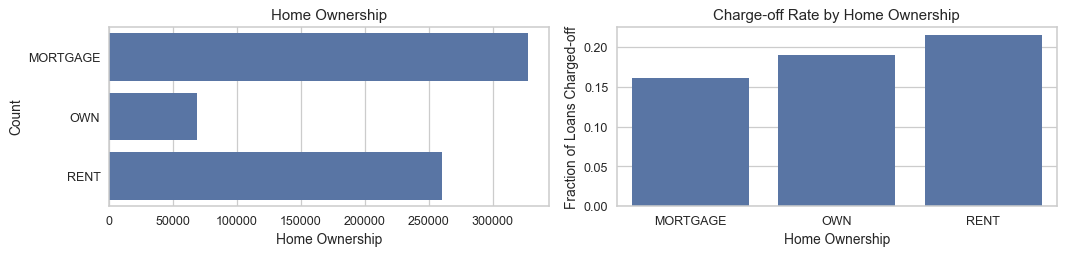

In [48]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

Those who rent are more likely to default when compared to Mortage or Own. 

In [49]:
subset_df.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:, 'Charged Off']

home_ownership
MORTGAGE    0.161336
OWN         0.189352
RENT        0.214401
Name: proportion, dtype: float64

### 3.8 annual_inc

Data Dictionary: The self-reported annual income provided by the borrower during registration.

In [50]:
subset_df['annual_inc'].describe()

count    6.562820e+05
mean     7.621171e+04
std      6.794131e+04
min      1.200000e+03
25%      4.600000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64

Annual income has a range from $1,200.00 to $9.5M. Because of the large ranges of income, we will use the natural log transform of the annual income variable.

In [51]:
subset_df['log_annual_income'] = subset_df['annual_inc'].apply(lambda x: np.log10(x+1))

In [52]:
subset_df.drop('annual_inc', axis=1, inplace=True)

In [53]:
subset_df['log_annual_income'].describe()

count    656282.000000
mean          4.815758
std           0.230447
min           3.079543
25%           4.662767
50%           4.812920
75%           4.954247
max           6.977724
Name: log_annual_income, dtype: float64

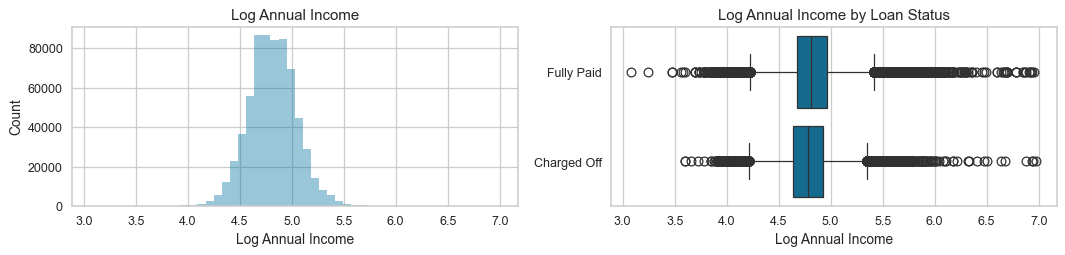

In [54]:
plot_var('log_annual_income', 'Log Annual Income', continuous=True)

Very intuitively, we can see that higher income borrowers are more likely to pay off their loan. 

In [55]:
subset_df.groupby('loan_status')['log_annual_income'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,121610.0,4.782857,0.222522,3.602169,4.640293,4.778158,4.924284,6.977724
Fully Paid,534672.0,4.823241,0.231561,3.079543,4.672107,4.812920,4.968488,6.954243


### 3.9 verification_status

Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

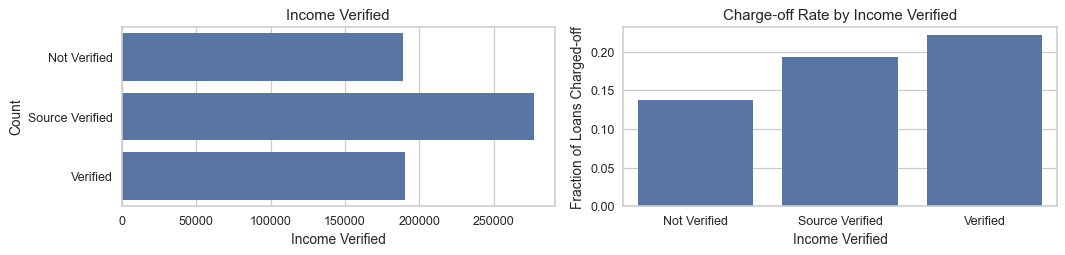

In [56]:
plot_var('verification_status', 'Income Verified', continuous=False)

### 3.10 issue_d

Data Dictionary: "The month which the loan was funded."

Because we're only using variables available to investors before the loan was funded, issue_d will not be included in the final model. We're keeping it for now just to perform the train/test split later, then we'll drop it.

<Axes: >

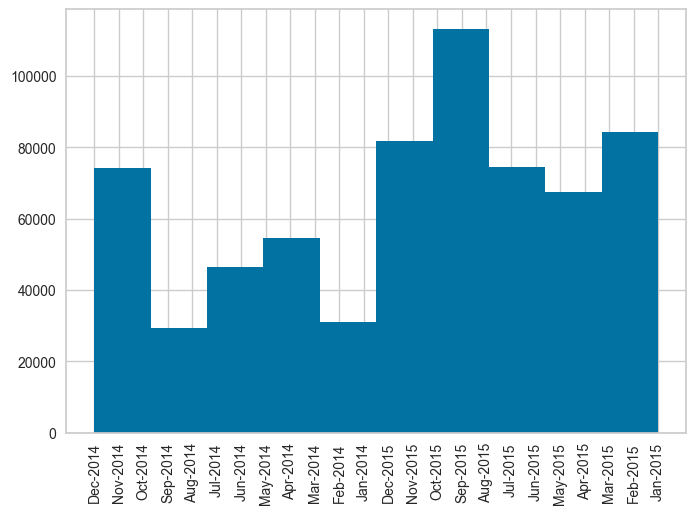

In [57]:
subset_df['issue_d'].hist(xrot=90)

In [58]:
# Convert this attribute into a datetime object
subset_df['issue_d'] = pd.to_datetime(subset_df['issue_d'], errors='coerce')

### 3.11 loan_status

Data Dictionary: Reflects whether loan was paid off or defaulted.

In [59]:
subset_df['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid     0.814699
Charged Off    0.185301
Name: proportion, dtype: float64

Roughly 81% of the entire subset_df consists of Fully Paid loans. This means that the model accuracies will be biased toward accurately predicting Fully Paid off loans as opposed to predicting defaults. 

### 3.12 purpose

Data Dictionary: A category provided by the borrower for the loan request. 

In [60]:
subset_df['purpose'].value_counts(normalize=True)

purpose
debt_consolidation    0.598508
credit_card           0.239978
home_improvement      0.058364
other                 0.044984
major_purchase        0.017208
medical               0.009523
small_business        0.008579
car                   0.008065
moving                0.005699
vacation              0.005217
house                 0.003329
renewable_energy      0.000527
wedding               0.000018
educational           0.000002
Name: proportion, dtype: float64

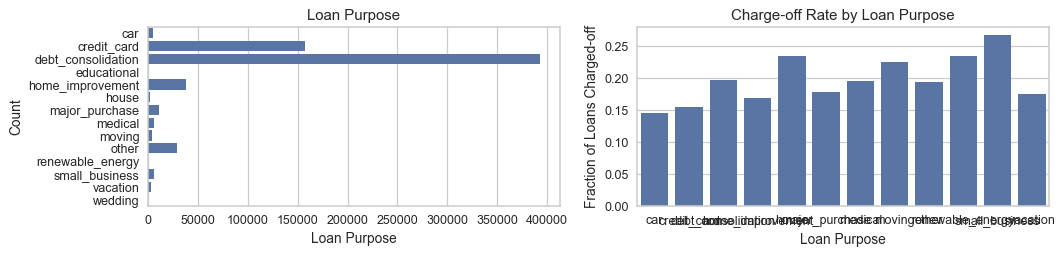

In [61]:
plot_var('purpose', 'Loan Purpose', continuous=False)

Why Consolidate?

1. Low Predictive Power: Categories with very few observations (like “wedding” or “educational”) may not have enough data to contribute meaningfully to the analysis or machine learning model. Including them could add noise rather than signal.
2. Model Stability: By reducing the number of small, infrequent categories, you make the dataset more stable for models like decision trees or logistic regression, which can struggle with very small groups.
3. Simplicity and Interpretability: Combining the smaller categories makes your model easier to interpret and reduces complexity. Instead of having many small categories with limited data, you can focus on the major ones and lump the less frequent ones together.

In [62]:
# Set threshold for consolidation
threshold = 0.01

# Find categories with a proportion below the threshold
small_categories = subset_df['purpose'].value_counts(normalize=True)[subset_df['purpose'].value_counts(normalize=True) < threshold].index

# Replace small categories with "Other"
subset_df['purpose'] = subset_df['purpose'].replace(to_replace=small_categories, value='other')

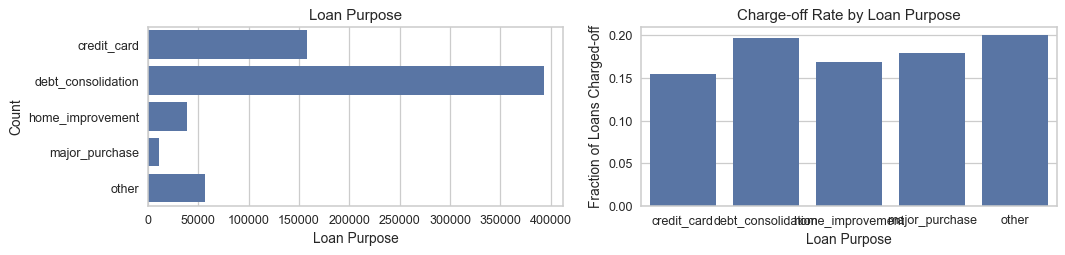

In [63]:
plot_var('purpose', 'Loan Purpose', continuous=False)

In [64]:
subset_df.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:, "Charged Off"].sort_values()

purpose
credit_card           0.155029
home_improvement      0.168525
major_purchase        0.179049
debt_consolidation    0.197172
other                 0.199812
Name: proportion, dtype: float64

### 3.13 dti

Data Dictionary: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [65]:
subset_df['dti'].describe()

count    656282.000000
mean         18.750985
std           8.601558
min           0.000000
25%          12.370000
50%          18.230000
75%          24.760000
max         999.000000
Name: dti, dtype: float64

In [66]:
len(subset_df[subset_df['dti'] > 100])

9

Since there are only 9 loans in the whole dataset above 100 (debt has exceeded their income), we can perform Capping (Winsorizing) the outliers. 

Instead of removing the outliers, we can cap the extreme values at a certain threshold. This approach is useful when the outliers are genuine but extreme. Since only 9 values are above 100, we might consider capping them to a reasonable maximum value (e.g., the 99th percentile).

This ensures that outliers don’t have a disproportionate impact on our model, while still preserving the overall data structure.

In [67]:
# Cap the 'dti' values at 100
subset_df['dti'] = np.where(subset_df['dti'] > 100, 100, subset_df['dti'])

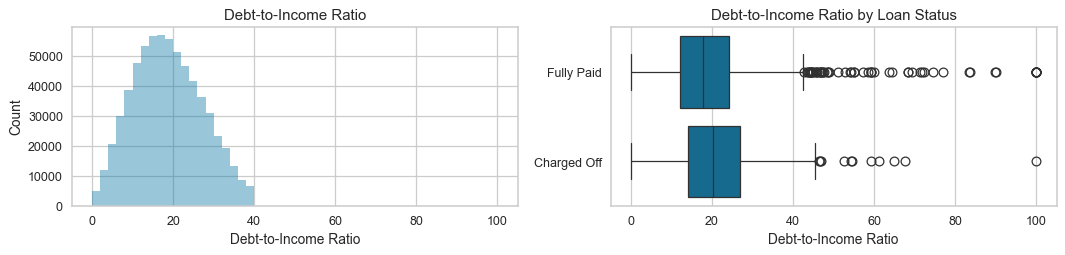

In [68]:
plot_var('dti', 'Debt-to-Income Ratio', continuous=True)

We can see that higher debt-to-income ratios tend to lead to more defaults. As can be seen from this distribution on the right, the Fully Paid off loans with higher debt-to-income ratios are the outliers. 

In [69]:
subset_df.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,121610.0,20.501573,8.597811,0.0,14.10,20.29,26.83,100.0
Fully Paid,534672.0,18.349309,8.384148,0.0,12.04,17.79,24.23,100.0


### 3.14 delinq_2yrs

Data Dictionary: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.

In [70]:
subset_df['delinq_2yrs'].value_counts(normalize=True)

delinq_2yrs
0.0     0.793008
1.0     0.135326
2.0     0.041214
3.0     0.015138
4.0     0.006939
5.0     0.003538
6.0     0.001931
7.0     0.001050
8.0     0.000631
9.0     0.000392
10.0    0.000265
11.0    0.000165
12.0    0.000123
13.0    0.000091
14.0    0.000067
15.0    0.000040
16.0    0.000026
17.0    0.000014
19.0    0.000012
18.0    0.000012
22.0    0.000005
21.0    0.000003
26.0    0.000003
20.0    0.000003
30.0    0.000002
27.0    0.000002
39.0    0.000002
Name: proportion, dtype: float64

Binning into Categories:

Since the vast majority of the data falls within the range of 0-3 delinquencies, we can group the higher values (4 and above) into a single category. This approach reduces the number of distinct values and makes the feature more manageable.

We could create bins like this:

•	0 delinquencies: 0

•	1 delinquency: 1

•	2 delinquencies: 2

•	3 delinquencies: 3

•	4+ delinquencies: 4 or “4+”

In [71]:
subset_df['delinq_2yrs_binned'] = pd.cut(subset_df['delinq_2yrs'],
                                         bins=[-1, 0, 1, 2, 3, float('inf')],
                                         labels=['0', '1', '2', '3', '4+'])

In [72]:
subset_df['delinq_2yrs_binned'].value_counts().sort_index()

delinq_2yrs_binned
0     520437
1      88812
2      27048
3       9935
4+     10050
Name: count, dtype: int64

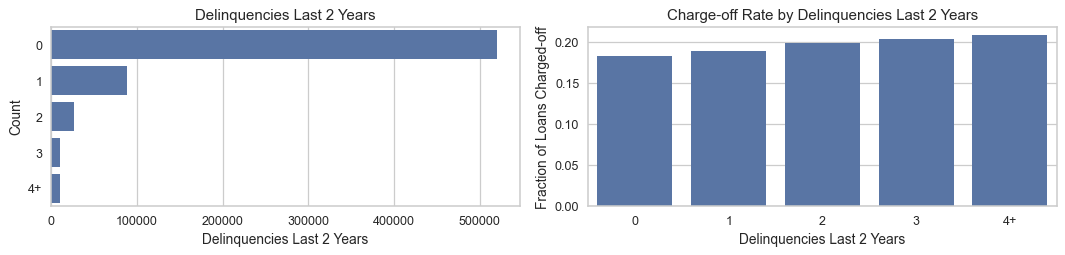

In [73]:
plot_var('delinq_2yrs_binned', 'Delinquencies Last 2 Years', continuous=False)

Since we discovered that the distribution is still so skewed to no delinquencies reported int he last 2 years and the charge off rate is barely effected, we can go about changing this to a binary variable and then dropping the binned and regular delinquencies columns. 

In [74]:
subset_df['has_delinq'] = subset_df['delinq_2yrs'].apply(lambda x: 1 if x > 0 else 0)

In [75]:
subset_df.groupby('has_delinq')['loan_status'].value_counts(normalize=True).loc[:, "Charged Off"]

has_delinq
0    0.183169
1    0.193470
Name: proportion, dtype: float64

In [76]:
subset_df.drop(columns=['delinq_2yrs', 'delinq_2yrs_binned'], inplace=True)

### 3.15 earliest_cr_line

Data Dictionary: The date the borrower's earliest reported credit line was opened.

In [77]:
subset_df['earliest_cr_line'].sample(5)

575112    May-2002
537564    Sep-2000
177190    Jan-1990
181851    Mar-2000
285979    Jul-1996
Name: earliest_cr_line, dtype: object

In [78]:
# Convert this attribute into a datetime object
subset_df['earliest_cr_line'] = pd.to_datetime(subset_df['earliest_cr_line'], errors='coerce')

<Axes: >

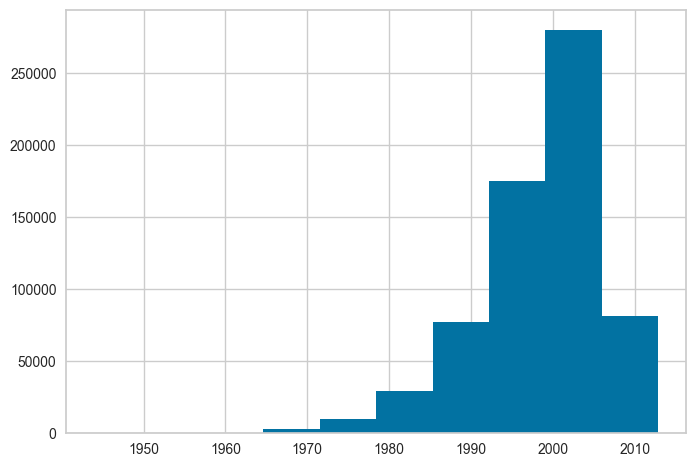

In [79]:
subset_df['earliest_cr_line'].hist()

### 3.16 open_acc

Data Dictionary: The number of open credit lines in the borrower's credit file.

In [80]:
subset_df['open_acc'].describe()

count    656282.000000
mean         11.848772
std           5.506689
min           0.000000
25%           8.000000
50%          11.000000
75%          15.000000
max          90.000000
Name: open_acc, dtype: float64

<Axes: >

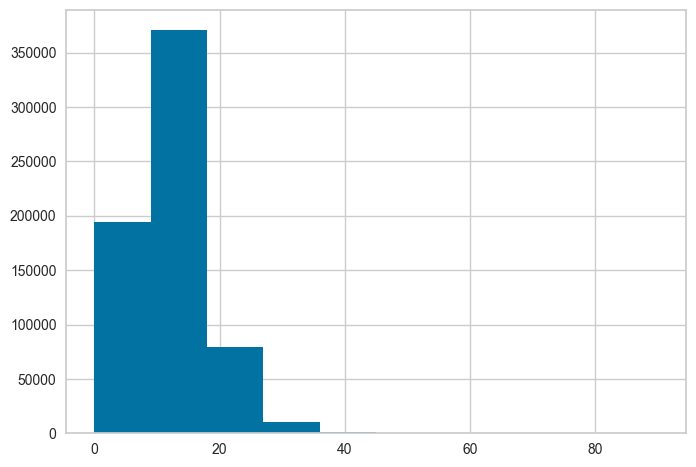

In [81]:
subset_df['open_acc'].hist()

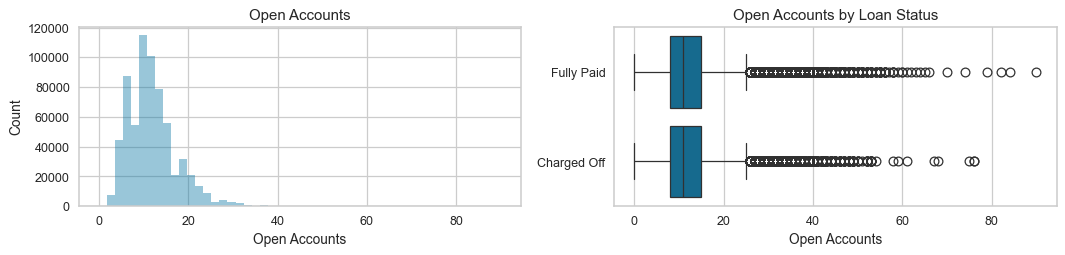

In [82]:
plot_var('open_acc', 'Open Accounts', continuous=True)

In [83]:
subset_df.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,121610.0,12.208864,5.659025,0.0,8.0,11.0,15.0,76.0
Fully Paid,534672.0,11.766870,5.468145,0.0,8.0,11.0,15.0,90.0


### 3.17 pub_rec

Data Dictionary: Number of derogatory public records. 

In [84]:
subset_df['pub_rec'].describe()

count    656282.000000
mean          0.229750
std           0.634059
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          86.000000
Name: pub_rec, dtype: float64

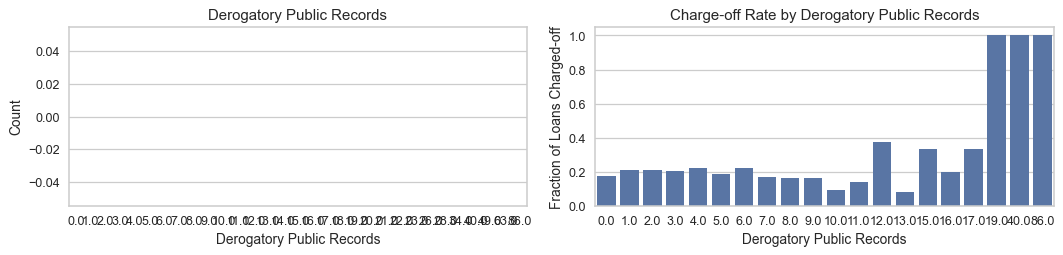

In [85]:
plot_var('pub_rec', 'Derogatory Public Records', continuous=False)

In [86]:
len(subset_df[subset_df['pub_rec'] > 0])

115878

In [87]:
len(subset_df[subset_df['pub_rec'] == 0])

540404

It appears that the all the records greater than zero still don't even make up half of the borrowers with no public records. So, we can create a binary variable and drop this feature from the dataset. 

In [88]:
subset_df['has_pub_records'] = subset_df['pub_rec'].apply(lambda x: 1 if x > 0 else 0)

In [89]:
subset_df.drop(columns='pub_rec', inplace=True)

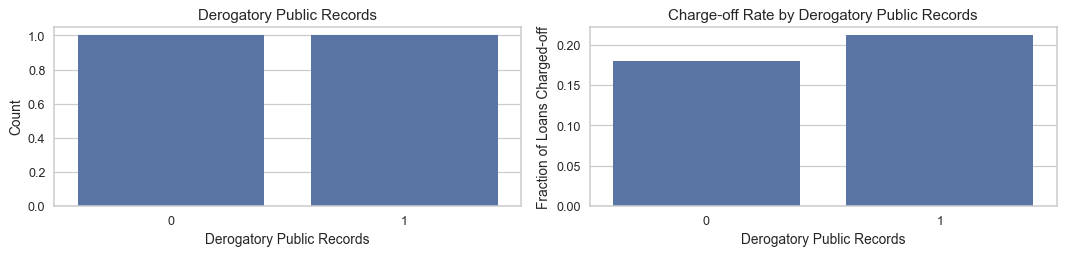

In [90]:
plot_var('has_pub_records', 'Derogatory Public Records', continuous=False)

In [91]:
subset_df.groupby('loan_status')['has_pub_records'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,121610.0,0.201332,0.400997,0.0,0.0,0.0,0.0,1.0
Fully Paid,534672.0,0.170935,0.376452,0.0,0.0,0.0,0.0,1.0


### 3.18 revol_bal

Data Dictionary: Total credit revolving balance

In [92]:
subset_df['revol_bal'].describe()

count    6.562820e+05
mean     1.726554e+04
std      2.326230e+04
min      0.000000e+00
25%      6.427000e+03
50%      1.188800e+04
75%      2.109600e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

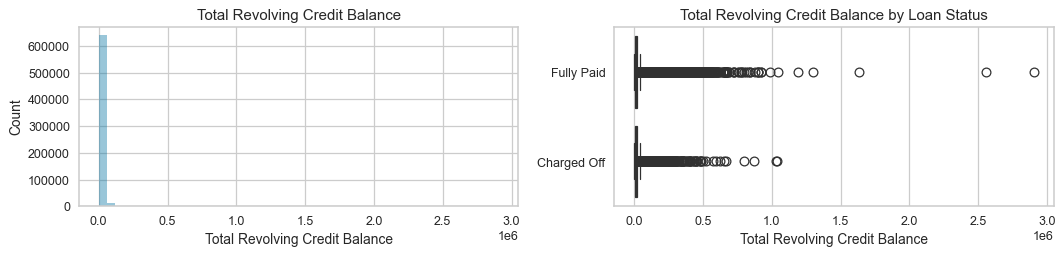

In [93]:
plot_var('revol_bal', 'Total Revolving Credit Balance', continuous=True)

As can be seen from the chart on the right, there are plenty of outliers in the dataset. We are going to take the log transform of this feature and remove the original feature.

In [94]:
subset_df['log_revol_bal'] = subset_df['revol_bal'].apply(lambda x: np.log10(x+1))

In [95]:
subset_df.drop('revol_bal', axis=1, inplace=True)

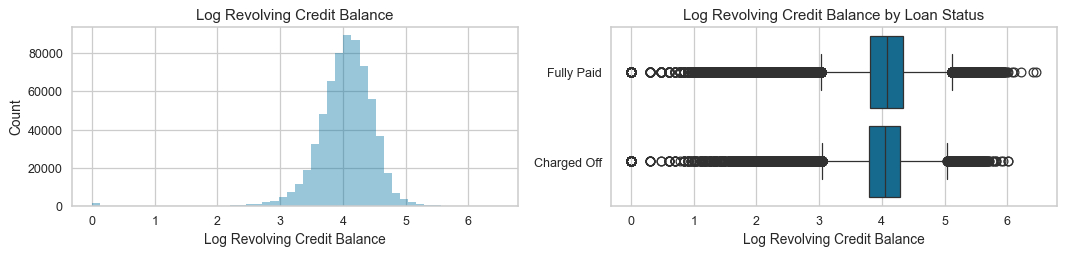

In [96]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

### 3.19 revol_util

Data Dictionary: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [97]:
subset_df['revol_util'].describe()

count    656282.000000
mean         54.504877
std          23.616034
min           0.000000
25%          37.100000
50%          55.000000
75%          72.600000
max         892.300000
Name: revol_util, dtype: float64

892 seems very high for this feature. This would mean that somehow this individual is using over 8 times their available revolving credit. We are going to cap the revol_util rate at 1 or 100%. 

In [98]:
len(subset_df[subset_df['revol_util'] > 100])

3215

In [99]:
# Cap the 'revol_util' values at 100
subset_df['revol_util'] = np.where(subset_df['revol_util'] > 100, 100, subset_df['revol_util'])

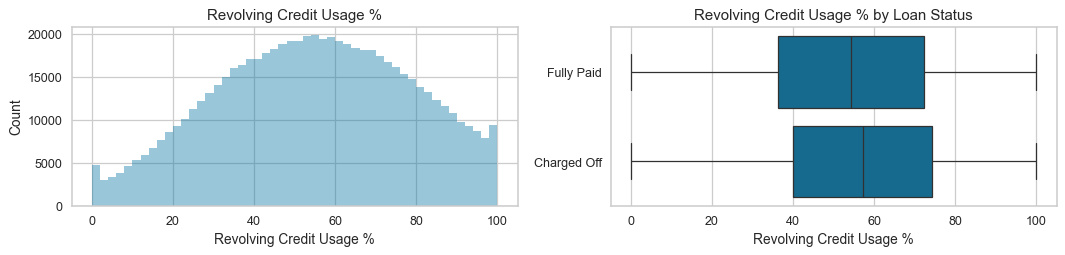

In [100]:
plot_var('revol_util', 'Revolving Credit Usage %', continuous=True)

In [101]:
subset_df.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,121610.0,56.591392,23.034173,0.0,40.0,57.3,74.3,100.0
Fully Paid,534672.0,54.008427,23.643764,0.0,36.4,54.4,72.2,100.0


### 3.20 last_pymnt_d

Data Dictionary: Date of last payment.

In [102]:
# Convert this attribute into a datetime object
subset_df['last_pymnt_d'] = pd.to_datetime(subset_df['last_pymnt_d'], errors='coerce')

In [103]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 656282 entries, 0 to 656725
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   loan_amnt            656282 non-null  float64       
 1   funded_amnt          656282 non-null  float64       
 2   term                 656282 non-null  int8          
 3   int_rate             656282 non-null  float64       
 4   grade                656282 non-null  object        
 5   emp_length           656282 non-null  int8          
 6   home_ownership       656282 non-null  object        
 7   verification_status  656282 non-null  object        
 8   issue_d              656282 non-null  datetime64[ns]
 9   loan_status          656282 non-null  object        
 10  purpose              656282 non-null  object        
 11  dti                  656282 non-null  float64       
 12  earliest_cr_line     656282 non-null  datetime64[ns]
 13  open_acc           

## Calculate Returns for Each Loan

In [104]:
# Define the names of the five returns we'll be calculating
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc"]

In [105]:
# Remove all rows for loans that were paid back on the days
# they were issued
subset_df['loan_length'] = (subset_df.last_pymnt_d - subset_df.issue_d) / np.timedelta64(1, 'M')
n_rows = len(subset_df)
subset_df = subset_df[subset_df.loan_length != 0]
print("Removed " + str(n_rows - len(subset_df)) + " rows")

Removed 1125 rows


### Method 1: Pessimistic Return (ret_PESS)

Assuming we want to avoid this complexity,
the following three methods are among the
most obvious ways to convert this to a static problem.
Before we list these methods, we define the
following notation:
- f is the total amount invested in the loan.
- p is the total amount repaid and recovered
from the loan, including monthly repayments,
and any recoveries received later.
- t is the nominal length of the loan in months
(i.e., the time horizon the loan was initially
issued for; this will be 36 or 60 months).
- m is the actual length of the loan in
months—the number of months from the
date the loan was issued to the date the last
payment was made.

Method 1 (M1—Pessimistic) supposes that,
once the loan is paid back, the investor is
forced to sit with the money without reinvesting
it anywhere else until the term of
the loan. In some sense, this is a worstcase
scenario—interest is only earned until
the loan is repaid, but the investor cannot
reinvest.
Under this assumption, the (annualized)
return can be calculated as


((p - f) / f) * (12 / t)


In [106]:
subset_df['ret_PESS'] = ((subset_df.total_pymnt - subset_df.funded_amnt) / subset_df.funded_amnt) * (12 / subset_df['term'])

### Method 2: Optimistic Return (ret_OPT)

Method 2 (M2—Optimistic) supposes that,
once the loan is paid back, the investor’s
money is returned and the investor can immediately
invest in another loan with exactly
the same return.
In that case, the (annualized) return can
easily be calculated as:

((p - f) / f) * (12 / m)

In [107]:
subset_df['ret_OPT'] = ((subset_df.total_pymnt - subset_df.funded_amnt) / subset_df.funded_amnt ) * (12 / subset_df['loan_length'])
subset_df.loc[subset_df.ret_OPT < 0,'ret_OPT'] = subset_df.ret_PESS[subset_df.ret_OPT < 0]

### Method 3: Reinvesting

The key steps of Method 3:

1.	Fixed Time Horizon:

	•	You’re looking at returns over a specific period, e.g., 60 months (5 years).

	•	Any money you get from loan payments during these 60 months is reinvested (put back into the market).
	
2.	Reinvesting Payments:

	•	Imagine you get monthly payments from the loan. Instead of just holding onto that money, you reinvest it at a fixed interest rate (let’s say i%).

	•	The assumption is that you reinvest each payment at the same rate, compounded monthly (meaning the interest you earn each month is added to the principal, and you earn interest on that new total the next month).

3.	The Benefit:

	•	This method tries to be realistic by simulating what would happen if you kept reinvesting any payments you received. It compares loans of different lengths more fairly and accounts for situations where a borrower defaults (fails to pay back the loan).

4.	The Downside:

	•	It undervalues the time value of money. This means it assumes you’re reinvesting at a fixed interest rate, but in reality, you might not always find good reinvestment opportunities at that same rate. You could invest in something riskier for a higher return.

The Mathematical Formula (Simplified):

The formula calculates the total return on your initial investment after reinvesting the payments over the 5-year period. Without diving too deep into the math, here’s a simpler breakdown:

•	You invest a certain amount at the start (let’s call it f).

•	The loan gives you monthly payments of p/m (where p is the total amount of payments, and m is the length of the loan in months).

•	These payments are reinvested at the interest rate i% each month.

•	The formula sums up how much you will have at the end of the 60 months, considering both the original investment and the reinvested payments.

Why Use This Method?

This method is useful because:

•	It levels the playing field between loans with different lengths and payment structures.

•	It gives a more realistic picture of returns by assuming that you keep investing any payments you receive.

Summary:

Method 3 assumes that when you get paid from a loan, you reinvest that money at a fixed interest rate. This helps calculate your total return after 5 years. The idea is to make the return calculation more realistic, but it has limitations since it might not always match real-life scenarios, where you might invest in different kinds of assets.


In [108]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''

    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (subset_df.total_pymnt - subset_df.recoveries) / subset_df['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, subset_df.loan_length)) / (1 - (1 + i))

    cash_by_end_of_loan = cash_by_end_of_loan + subset_df.recoveries

    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - subset_df['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - subset_df['funded_amnt'] ) / subset_df['funded_amnt'] ) )

subset_df['ret_INTa'] = ret_method_3(5 * 12, 0.001)
subset_df['ret_INTb'] = ret_method_3(5 * 12, 0.0025)
subset_df['ret_INTc'] = ret_method_3(5 * 12, 0.005)

In [109]:
subset_df.isna().sum()

loan_amnt              0
funded_amnt            0
term                   0
int_rate               0
grade                  0
emp_length             0
home_ownership         0
verification_status    0
issue_d                0
loan_status            0
purpose                0
dti                    0
earliest_cr_line       0
open_acc               0
revol_util             0
total_pymnt            0
recoveries             0
last_pymnt_d           0
log_annual_income      0
has_delinq             0
has_pub_records        0
log_revol_bal          0
loan_length            0
ret_PESS               0
ret_OPT                0
ret_INTa               0
ret_INTb               0
ret_INTc               0
dtype: int64

## Data Preparation for Modeling

In [110]:
subset_df['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid     0.814382
Charged Off    0.185618
Name: proportion, dtype: float64

We need to create a binary outcome (True: Loan Default /False: Non-Default) column for loan default classificiation and prediction.

In [111]:
# Create the outcome
subset_df["outcome"] = subset_df.loan_status.isin(["Charged Off", "Default"])

# Create a feature for the length of a person's credit history at the
# time the loan is issued
subset_df['cr_hist'] = (subset_df.issue_d - subset_df.earliest_cr_line) / np.timedelta64(1, 'M')

In [112]:
subset_df.reset_index(inplace=True, drop=True)

In [113]:
# Store the cleaned data frame as data
data = subset_df.copy()

In [114]:
np.random.seed(default_seed)

# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

In [115]:
data['train'].value_counts(normalize=True)

train
True     0.69986
False    0.30014
Name: proportion, dtype: float64

We can see that the boolean mask column (train) is correctly splitting up the data for 70% of the dataset dedicated to training versus 30% dedicated to testing. 

In [116]:
# Create lists of continuous and discrete features
continuous_features = ['loan_amnt', 'int_rate', 'emp_length', 'dti', 'open_acc',
                       'revol_util', 'log_annual_income', 'has_delinq', 'has_pub_records',
                       'log_revol_bal', 'cr_hist']

discrete_features = ['grade', 'home_ownership', 'verification_status', 'purpose']

Converting a pandas DataFrame into a NumPy array, as shown in our code, serves several purposes, especially when preparing data for machine learning models. Let’s break this down in terms of the context of data processing:

1. Compatibility with Machine Learning Libraries

Many machine learning libraries and algorithms (like scikit-learn, TensorFlow, etc.) expect data in a NumPy array format rather than a pandas DataFrame. By converting the DataFrame into a NumPy array:

- Performance: NumPy arrays are generally more efficient in terms of computation speed and memory usage than pandas DataFrames, especially for large datasets.

- Consistency: It ensures consistency when passing data to these libraries since they may not handle pandas objects as efficiently or as expected.


2. Simplicity and Speed

- Vectorized Operations: NumPy arrays allow for more efficient, element-wise, vectorized operations, which are faster than operations on DataFrames, especially for mathematical computations (like normalization, transformations, etc.).

- No Overhead: Pandas DataFrames come with additional overhead (indexing, column names, etc.), which isn’t needed for certain operations, especially when all that’s required is the raw data.

3. Dimensionality Consistency

- When preparing the feature matrix X for machine learning, we need a consistent structure of rows (samples) and columns (features). Converting to a NumPy array ensures that all data is purely numeric and in a homogeneous format, which is required for most modeling tasks.

- It avoids issues related to pandas DataFrame indexing or row/column misalignments.

4. Pure Numerical Representation

- When we extract .values, we are converting the DataFrame into a raw numerical matrix. This is essential for algorithms that require all features to be in numerical form, without metadata like DataFrame indices or column names.

- It strips away all extra information (like labels or categorical data that may still be in pandas) and leaves only the continuous values needed for model training.

5. Batch Processing & Broadcasting

- NumPy arrays allow for batch processing and broadcasting (applying operations to entire datasets at once without looping). This is critical for tasks like standardization, scaling, or applying activation functions in neural networks.

In [117]:
# Convert pandas data frame into a np.array
X_continuous = data[continuous_features].values
X_continuous

array([[1.50000000e+04, 1.23900000e+01, 1.00000000e+01, ...,
        0.00000000e+00, 5.13990741e+00, 2.39580645e+02],
       [1.04000000e+04, 6.99000000e+00, 8.00000000e+00, ...,
        0.00000000e+00, 3.78774377e+00, 2.97483871e+02],
       [7.65000000e+03, 1.36600000e+01, 0.00000000e+00, ...,
        0.00000000e+00, 4.22590344e+00, 1.45322581e+02],
       ...,
       [1.20000000e+04, 1.99900000e+01, 1.00000000e+00, ...,
        0.00000000e+00, 3.91671708e+00, 1.32580645e+02],
       [1.30000000e+04, 1.59900000e+01, 5.00000000e+00, ...,
        1.00000000e+00, 4.04265425e+00, 1.33548387e+02],
       [2.00000000e+04, 1.19900000e+01, 1.00000000e+01, ...,
        1.00000000e+00, 4.52201364e+00, 1.54161290e+02]])

We need to one-hot encode the discrete variables. This will allow the machine learning model to use this data. 

In [118]:
X_discrete = pd.get_dummies(data[discrete_features], prefix_sep = "::", drop_first = True)
X_discrete

,grade::B,grade::C,grade::D,grade::E,grade::F,grade::G,home_ownership::OWN,home_ownership::RENT,verification_status::Source Verified,verification_status::Verified,purpose::debt_consolidation,purpose::home_improvement,purpose::major_purchase,purpose::other
0,False,True,False,False,False,False,False,True,True,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,True,True,False,True,False,False,False
3,False,False,True,False,False,False,False,False,False,True,False,False,False,True
4,False,False,True,False,False,False,False,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655152,True,False,False,False,False,False,False,True,False,True,True,False,False,False
655153,True,False,False,False,False,False,False,False,False,True,False,True,False,False
655154,False,False,False,True,False,False,False,True,True,False,True,False,False,False
655155,False,False,True,False,False,False,False,True,False,True,True,False,False,False


In [119]:
discrete_features_dummies = X_discrete.columns.tolist()
discrete_features_dummies

['grade::B',
 'grade::C',
 'grade::D',
 'grade::E',
 'grade::F',
 'grade::G',
 'home_ownership::OWN',
 'home_ownership::RENT',
 'verification_status::Source Verified',
 'verification_status::Verified',
 'purpose::debt_consolidation',
 'purpose::home_improvement',
 'purpose::major_purchase',
 'purpose::other']

Convert the pandas dataframe into a numpy array for all discrete features. We do this for reasons discussed before.

In [120]:
X_discrete = X_discrete.values
X_discrete

array([[False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

In [121]:
# Combine the continuous features with the discrete features
X = np.concatenate((X_continuous, X_discrete), axis=1)
X

array([[1.500e+04, 1.239e+01, 1.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.040e+04, 6.990e+00, 8.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.650e+03, 1.366e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.200e+04, 1.999e+01, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.300e+04, 1.599e+01, 5.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+04, 1.199e+01, 1.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [122]:
# Convert the outcome or response variable to a numpy array
y = data.outcome.values

In [123]:
train = data.train.values

In [124]:
X.shape

(655157, 25)

In [125]:
# Find out cut off date to divide the data into 5/7 traininig data and 2/7 testing data
date_threshold = np.quantile(data['issue_d'], 5/7)
date_threshold

numpy.datetime64('2015-08-01T00:00:00.000000000')

In [126]:
date_range_train = (data.issue_d.min(), date_threshold)
date_range_train

(Timestamp('2014-01-01 00:00:00'),
 numpy.datetime64('2015-08-01T00:00:00.000000000'))

In [127]:
date_range_test = (date_threshold, data.issue_d.max())
date_range_test

(numpy.datetime64('2015-08-01T00:00:00.000000000'),
 Timestamp('2015-12-01 00:00:00'))

In the above timestamps, it appears our training/test split will occur at 08-01-2015.

### filter_train

This will include downsampling further to ensure class balance.

In [128]:
# Filter down the data to the required date range, and downsample
# as required
filter_train = (train &
                (data.issue_d >= date_range_train[0]) &
                (data.issue_d <= date_range_train[1]))
filter_train.value_counts()

issue_d
True     347568
False    307589
Name: count, dtype: int64

In [129]:
# Number of rows to keep for sampling the test set
n_samples_train = 50_000

# Convert the boolean filter to integer indices (where True)
true_indices = np.where(filter_train)[0]

# Randomly select indices to be set to False
selected_indices = np.random.choice(true_indices,
                                    size=filter_train.sum() - n_samples_train,
                                    replace=False)

# Ensure the selected indices match the original index of filter_train
filter_train.iloc[selected_indices] = False

filter_train.value_counts()

issue_d
False    605157
True      50000
Name: count, dtype: int64

When creating the filter_train set, we are doing the following:

Overall Purpose

-	Train-test split: We're splitting the dataset into two parts based on the issue date of loans:
-	Training set: Loans issued from 2014-01-01 to 2015-08-01.
-	Test set: Loans issued from 2015-08-01 to 2015-12-01.
- 	Downsampling: To reduce the size of the training set, we're randomly selecting a smaller subset (50,000 rows) of the training data. This is useful if the full dataset is too large to efficiently train the model on.

This method ensures a time-based split, which is especially important in tasks like time-series forecasting or financial modeling, where data leakage from future dates into the training set would skew model performance.

In [130]:
data['outcome'].value_counts()

outcome
False    533548
True     121609
Name: count, dtype: int64

Another thing to consider is the class imbalance--we have far more non-default loans for these models to be trained on. Therefore, we need to find a way to downsample to evenly distribute the classes for more accurate and balanced modeling.

In [131]:
# 1. Filter the training data by 'outcome'
default_loans = data.loc[filter_train & (data['outcome'] == True)]  # Default loans
non_default_loans = data.loc[filter_train & (data['outcome'] == False)]  # Non-default loans

# 2. Count the number of default and non-default loans
n_defaults = len(default_loans)
n_non_defaults = len(non_default_loans)

# 3. Determine how many non-default loans to downsample
if n_non_defaults > n_defaults:
    n_samples_non_defaults = n_defaults  # Balance non-defaults to match the defaults

    # 4. Randomly select a subset of non-default loans to match the number of defaults
    non_default_sample = non_default_loans.sample(n=n_samples_non_defaults, random_state=default_seed)

    # 5. Combine default loans and the downsampled non-default loans
    balanced_train = pd.concat([default_loans, non_default_sample])

else:
    # If non-defaults are fewer or equal, no downsampling is needed
    balanced_train = pd.concat([default_loans, non_default_loans])

# Check the class distribution in the balanced training set
balanced_train['outcome'].value_counts()

outcome
True     9182
False    9182
Name: count, dtype: int64

In [132]:
# Initialize filter_train to all False (no rows selected initially)
filter_train = pd.Series(False, index=data.index)

# Get the indices of the downsampled balanced train set
balanced_indices = balanced_train.index

# Update filter_train to reflect the rows that are in the balanced_train
filter_train.loc[balanced_indices] = True

# Check the updated filter_train distribution
filter_train.value_counts()

False    636793
True      18364
Name: count, dtype: int64

### filter_test

In [133]:
# Filter down the data to the required date range, and downsample
# as required
filter_test = ((train == False) &
                (data.issue_d >= date_range_test[0]) &
                (data.issue_d <= date_range_test[1]))
filter_test.value_counts()

issue_d
False    596786
True      58371
Name: count, dtype: int64

In [134]:
# Number of rows to keep for sampling the test set
n_samples_test = 10_000

# Convert the boolean filter to integer indices (where True)
true_indices = np.where(filter_test)[0]

# Randomly select indices to be set to False
selected_indices = np.random.choice(true_indices,
                                    size=filter_test.sum() - n_samples_test,
                                    replace=False)

# Ensure the selected indices match the original index of filter_train
filter_test.iloc[selected_indices] = False

filter_test.value_counts()

issue_d
False    645157
True      10000
Name: count, dtype: int64

In [135]:
# 1. Filter the testing data by 'outcome'
default_loans = data.loc[filter_test & (data['outcome'] == True)]  # Default loans
non_default_loans = data.loc[filter_test & (data['outcome'] == False)]  # Non-default loans

# 2. Count the number of default and non-default loans
n_defaults = len(default_loans)
n_non_defaults = len(non_default_loans)

# 3. Determine how many non-default loans to downsample
if n_non_defaults > n_defaults:
    n_samples_non_defaults = n_defaults  # Balance non-defaults to match the defaults

    # 4. Randomly select a subset of non-default loans to match the number of defaults
    non_default_sample = non_default_loans.sample(n=n_samples_non_defaults, random_state=default_seed)

    # 5. Combine default loans and the downsampled non-default loans
    balanced_train = pd.concat([default_loans, non_default_sample])

else:
    # If non-defaults are fewer or equal, no downsampling is needed
    balanced_train = pd.concat([default_loans, non_default_loans])

# Check the class distribution in the balanced testing set
balanced_train['outcome'].value_counts()

outcome
True     1893
False    1893
Name: count, dtype: int64

In [136]:
# Initialize filter_test to all False (no rows selected initially)
filter_test = pd.Series(False, index=data.index)

# Get the indices of the downsampled balanced train set
balanced_indices = balanced_train.index

# Update filter_test to reflect the rows that are in the balanced_train
filter_test.loc[balanced_indices] = True

# Check the updated filter_test distribution
filter_test.value_counts()

False    651371
True       3786
Name: count, dtype: int64

### Build X_train, X_test, y_train, y_test Datasets

In [137]:
X_train = X[filter_train, :]
X_test = X[filter_test, :]
y_train = y[filter_train]
y_test = y[filter_test]

In [138]:
# Validating that all subsets of data for modeling have the same
# number of rows
print(f"filter_train Length: {len(filter_train[filter_train==True])}")
print(f"X_train Length: {len(X_train)}")
print(f"y_train Length: {len(y_train)}\n")
print(f"filter_test Length: {len(filter_test[filter_test==True])}")
print(f"X_test Length: {len(X_test)}")
print(f"y_test Length: {len(y_test)}")

filter_train Length: 18364
X_train Length: 18364
y_train Length: 18364

filter_test Length: 3786
X_test Length: 3786
y_test Length: 3786


In [139]:
# Scale the variables
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [140]:
# Create a dictionary of datasets for classification 
# and regression functions going forward
data_dict = {
    'X_train':X_train,
    'y_train':y_train,
    'train_set':filter_train,
    'X_test':X_test,
    'y_test':y_test,
    'test_set':filter_test
}

In [141]:
data_dict['X_train']

array([[0.35220588, 0.52978454, 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.65661765, 0.37980566, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.51323529, 0.37980566, 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.2817913 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.47132353, 0.61977186, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28970588, 0.58808619, 0.6       , ..., 0.        , 0.        ,
        0.        ]])

# Classification Modeling

In [142]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [cv_model.param_grid[i][0], cv_model.param_grid[i][-1]]:
            out = True
            break
            
    return out

In [143]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)

    # Ensure `data.grade` is filtered the same way as `y_train_score`
    grade_train_filtered = data.grade[filter_train]
    grade_train_filtered = grade_train_filtered[:len(y_train_score)]  # Ensure matching length if needed

    tau, p_value = kendalltau(y_train_score, grade_train_filtered)
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

### $l_1$ penalized logistic regression

  Model: l1 Penalized Logistic Regression
Fit time: 32.08 seconds
Optimal parameters:
{'C': 4832.930238571752}

Accuracy-maximizing threshold was: 0.4803208931560822
Accuracy:  0.6487057580559957
              precision    recall  f1-score   support

  No default     0.6495    0.6461    0.6478      1893
     Default     0.6479    0.6513    0.6496      1893

    accuracy                         0.6487      3786
   macro avg     0.6487    0.6487    0.6487      3786
weighted avg     0.6487    0.6487    0.6487      3786



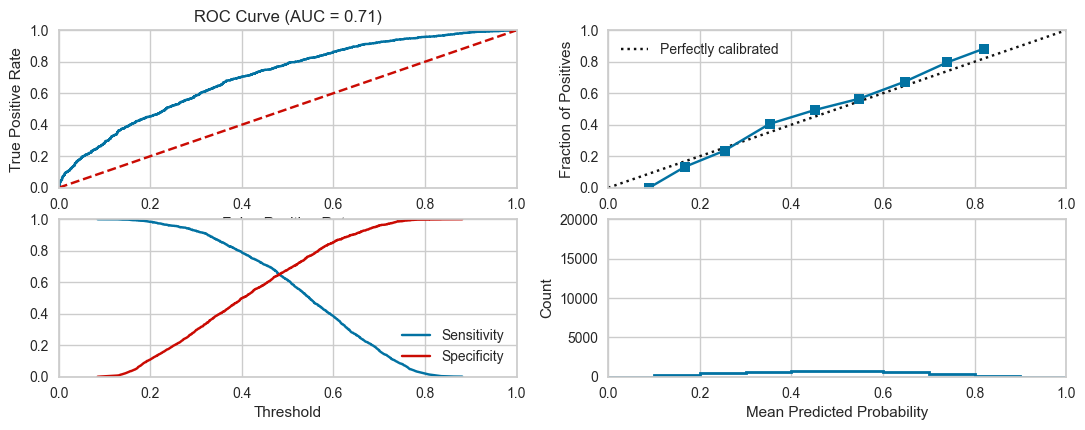


Similarity to LC grade ranking:  0.8025825177859336
Brier score: 0.2170267167163816


In [144]:
l1_logistic = LogisticRegression(penalty = 'l1', solver='liblinear')
cv_parameters = {"C":np.logspace(0, 10, num = 20)}
l1_logistic1415 = fit_classification(l1_logistic, 
                                     data_dict,
                                     cv_parameters = cv_parameters,
                                     output_to_file=False,
                                     model_name = "l1 Penalized Logistic Regression")

In [145]:
final_features = [i for i in discrete_features + continuous_features]
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]

## useful when choosing the most significant features
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

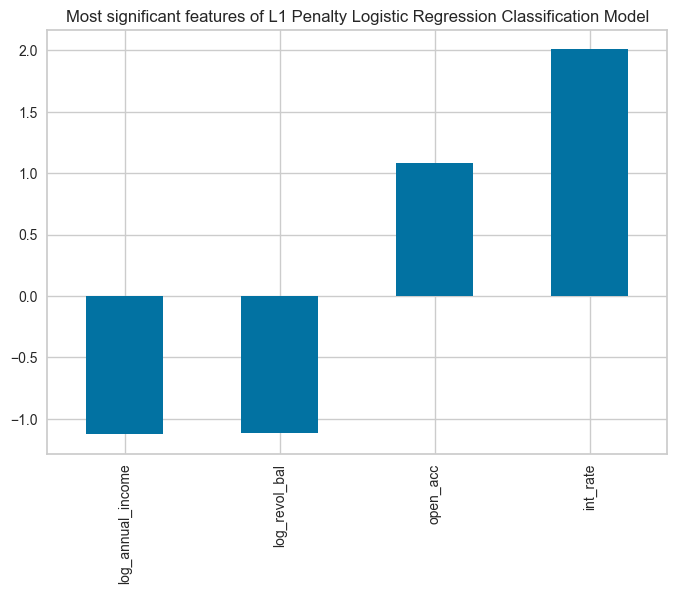

In [146]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l1_logistic1415['model'].coef_)[0,:2]) + list(np.argsort(l1_logistic1415['model'].coef_)[0,-2:])
bplot = pd.Series(l1_logistic1415['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=90)
p1.set_xticklabels(xticks)
plt.title('Most significant features of L1 Penalty Logistic Regression Classification Model')
plt.show()

In [147]:
coefficients = l1_logistic1415['model'].coef_[0]
coefficients

array([ 0.42942424,  2.00976442, -0.01890906,  0.48610223,  1.07959513,
        0.08770353, -1.1265915 ,  0.05396358,  0.14836701, -1.11570182,
       -0.12673164,  0.37904667,  0.6735242 ,  0.74828162,  0.91941156,
        0.75157312,  0.75138545,  0.21472879,  0.29213947,  0.11753061,
        0.10377662, -0.0068853 , -0.08383445, -0.26078688, -0.24561093])

In [148]:
coefficient_features = selected_features
coefficient_features

0                                loan_amnt
1                                 int_rate
2                               emp_length
3                                      dti
4                                 open_acc
5                               revol_util
6                        log_annual_income
7                               has_delinq
8                          has_pub_records
9                            log_revol_bal
10                                 cr_hist
11                                grade::B
12                                grade::C
13                                grade::D
14                                grade::E
15                                grade::F
16                                grade::G
17                     home_ownership::OWN
18                    home_ownership::RENT
19    verification_status::Source Verified
20           verification_status::Verified
21             purpose::debt_consolidation
22               purpose::home_improvement
23         

In [149]:
coefficient_df = pd.DataFrame({
    'features':coefficient_features,
    'coef':coefficients
})
coefficient_df

,features,coef
0,loan_amnt,0.429424
1,int_rate,2.009764
2,emp_length,-0.018909
3,dti,0.486102
4,open_acc,1.079595
5,revol_util,0.087704
6,log_annual_income,-1.126591
7,has_delinq,0.053964
8,has_pub_records,0.148367
9,log_revol_bal,-1.115702


### $l_2$ penalized logistic regression

  Model: l2 Penalized Logistic Regression
Fit time: 4.68 seconds
Optimal parameters:
{'C': 0.026366508987303555}

Accuracy-maximizing threshold was: 0.5069246863428852
Accuracy:  0.6447437929212889
              precision    recall  f1-score   support

  No default     0.6317    0.6941    0.6615      1893
     Default     0.6606    0.5954    0.6263      1893

    accuracy                         0.6447      3786
   macro avg     0.6462    0.6447    0.6439      3786
weighted avg     0.6462    0.6447    0.6439      3786



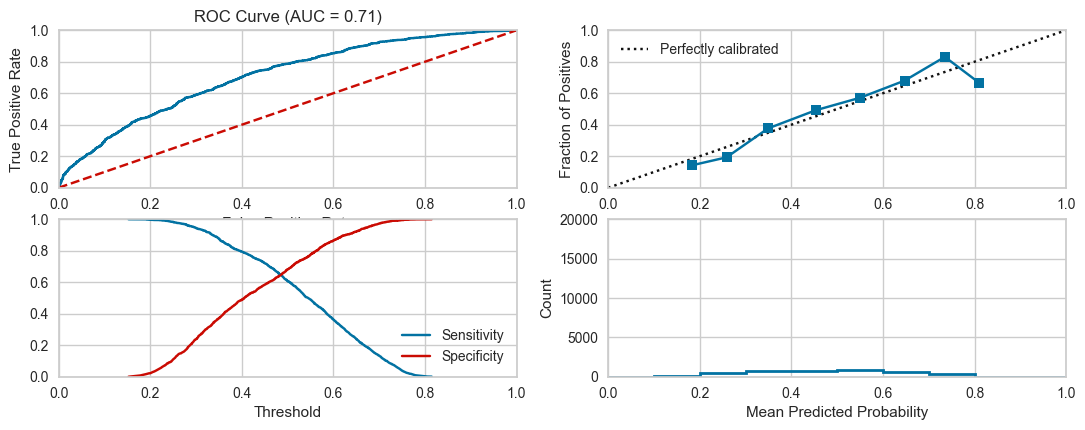


Similarity to LC grade ranking:  0.806727669641282
Brier score: 0.21799024799549904


In [150]:
l2_logistic = LogisticRegression(penalty = 'l2')
cv_parameters = {"C":np.logspace(-10, 10, num = 20)}

l2_logistic1415 = fit_classification(l2_logistic, 
                                     data_dict,
                                     cv_parameters=cv_parameters, 
                                     output_to_file=False,
                                     model_name="l2 Penalized Logistic Regression")


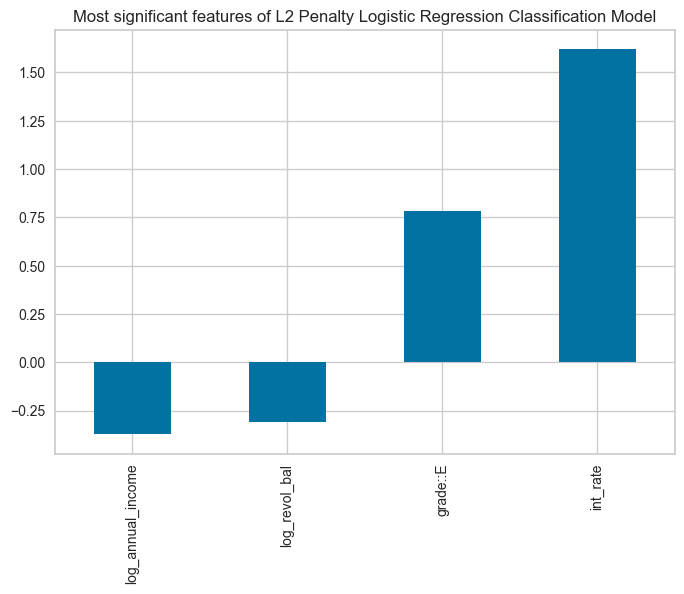

In [151]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic1415['model'].coef_)[0,:2]) + list(np.argsort(l2_logistic1415['model'].coef_)[0,-2:])
bplot = pd.Series(l2_logistic1415['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=90)
p1.set_xticklabels(xticks)
plt.title('Most significant features of L2 Penalty Logistic Regression Classification Model')
plt.show()

### Decision tree

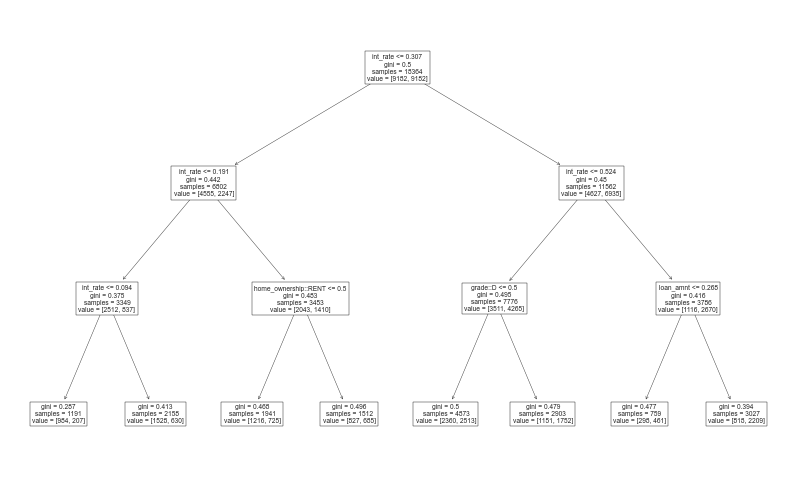

In [152]:
# Simple Decision Tree Models with pruning
max_depth = 3  # Specify the maximum depth of the tree
min_samples_split = 50  # Specify the minimum number of samples required to split an internal node

dtc_pruned = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
dtc_pruned.fit(data_dict['X_train'], data_dict['y_train'])

# Plot decision tree
plt.figure(figsize=(10, 6))
plot_tree(dtc_pruned,feature_names=selected_features)
plt.show()

  Model: Decision tree
Fit time: 1.39 seconds
Optimal parameters:
{'min_samples_leaf': 600}

Accuracy-maximizing threshold was: 0.5446559297218155
Accuracy:  0.6394611727416799
              precision    recall  f1-score   support

  No default     0.6142    0.7501    0.6754      1893
     Default     0.6791    0.5288    0.5946      1893

    accuracy                         0.6395      3786
   macro avg     0.6466    0.6395    0.6350      3786
weighted avg     0.6466    0.6395    0.6350      3786



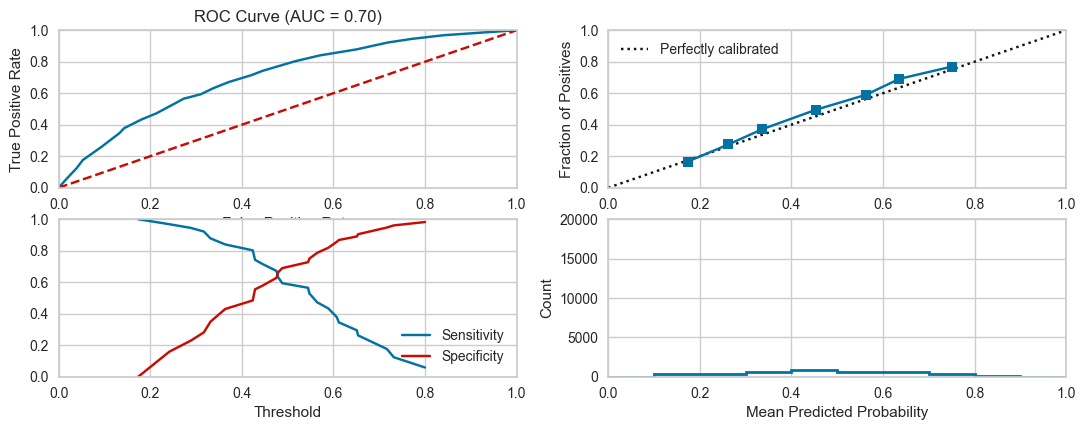


Similarity to LC grade ranking:  0.7872768604245867
Brier score: 0.2190568310416519


In [153]:
decision_tree = DecisionTreeClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

dt1415 = fit_classification(decision_tree, 
                            data_dict, 
                            cv_parameters=cv_parameters, 
                            output_to_file=False,
                            model_name = "Decision tree")

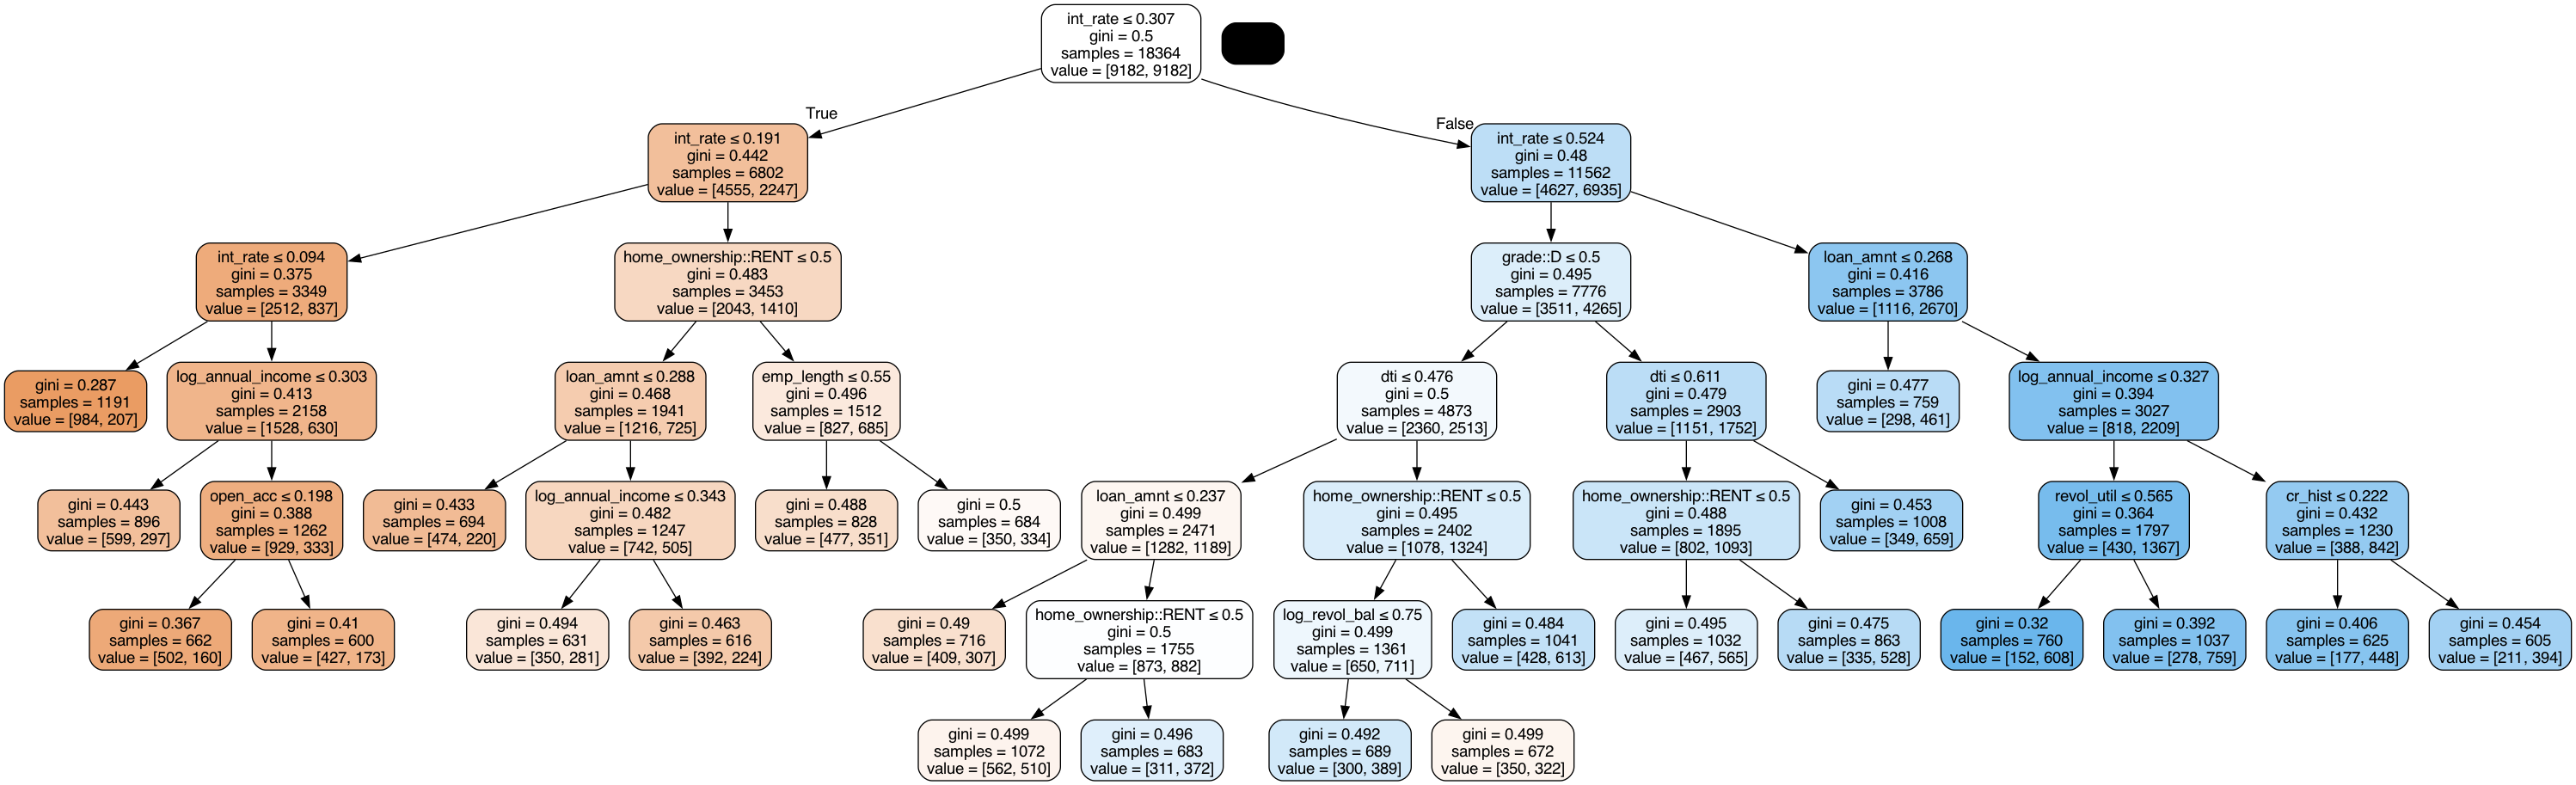

In [154]:
from six import StringIO
import graphviz

dot_data = StringIO()
export_graphviz(dt1415['model'], out_file=dot_data,  
                feature_names=selected_features,filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### ($\star$) Random forest
Takes nearly 10 minutes given the large data set! 
You can save the model and reload it for later use if you plan to re-use it later.

  Model: Random forest
Fit time: 276.53 seconds
Optimal parameters:
{'min_samples_leaf': 40, 'n_estimators': 35}

Accuracy-maximizing threshold was: 0.5182956666278091
Accuracy:  0.6492340200739567
              precision    recall  f1-score   support

  No default     0.6304    0.7216    0.6729      1893
     Default     0.6745    0.5769    0.6219      1893

    accuracy                         0.6492      3786
   macro avg     0.6524    0.6492    0.6474      3786
weighted avg     0.6524    0.6492    0.6474      3786



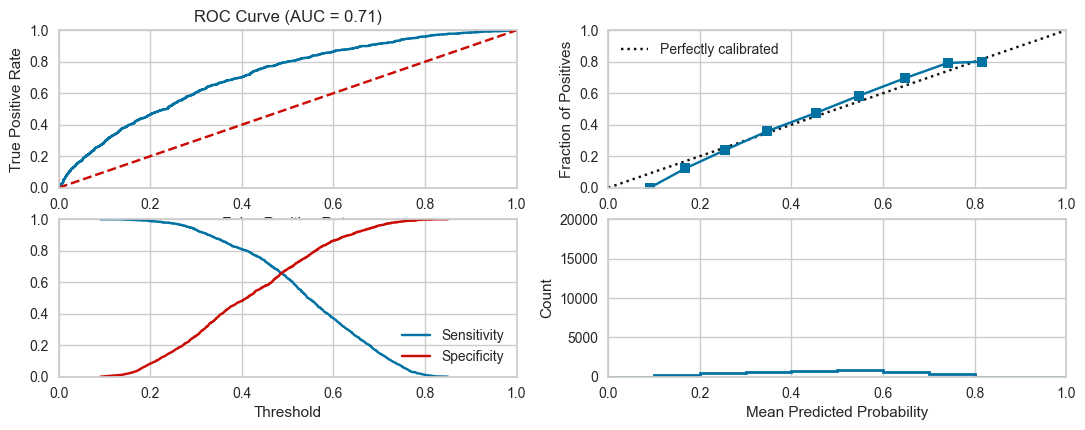


Similarity to LC grade ranking:  0.7875200208761511
Brier score: 0.21639736940033416


In [155]:
random_forest = RandomForestClassifier()
cv_parameters = {'min_samples_leaf':[1, 2, 3, 5, 8, 13, 17, 20, 40], 
                 'n_estimators': [35, 60, 80, 100, 150] }

rf1415 = fit_classification(random_forest, 
                            data_dict,
                            cv_parameters=cv_parameters, 
                            output_to_file=False,
                            model_name="Random forest")


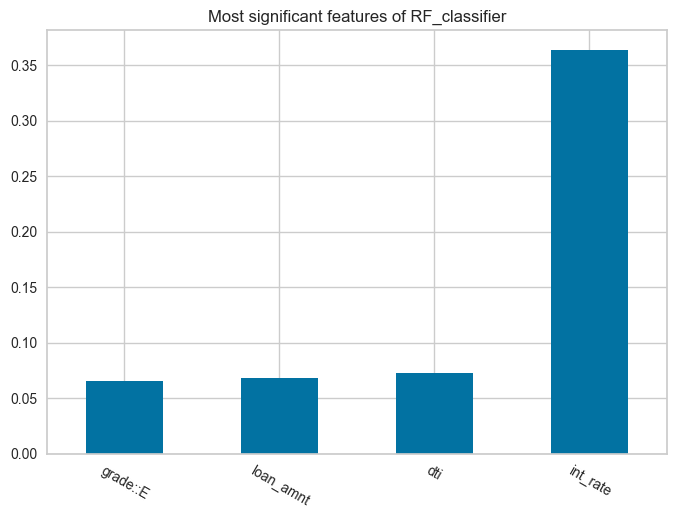

In [156]:
## Plot top 6 most significant features
top_idx = list(np.argsort(rf1415['model'].feature_importances_)[-4:]) 
bplot = pd.Series(rf1415['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30)
p2.set_xticklabels(xticks)
plt.title('Most significant features of RF_classifier')
plt.show()

# Regression Models

In [157]:
def fit_regression(model, 
                   data_dict,
                   cv_parameters={},
                   separate=False,
                   model_name=None,
                   random_state=default_seed,
                   output_to_file=True,
                   print_to_screen=True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen

    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''

    np.random.seed(random_state)

    # --------------------------
    #   Step 1 - Load the data
    # --------------------------

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    col_list = ['ret_INTb']

    X_train = data_dict['X_train']
    
    filter_train = data_dict['train_set']
    
    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']

    out = {}

    for ret_col in col_list:

        y_train = data.loc[filter_train, ret_col].to_numpy()
        
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_

            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)

            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_

            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### Lasso-Lars regressor

In [158]:
# First, trying LASSO penalized regression with a variety of parameters,
# it becomes clear a simple regression is best

cv_parameters = {'alpha':np.logspace(-8, -1, num = 8)}

reg_lasso1415 = fit_regression(linear_model.LassoLars(), 
                               data_dict,  
                               cv_parameters=cv_parameters, 
                               separate=False, 
                               output_to_file=False,
                               model_name="Lasso")

  Model: Lasso  Return column: ret_INTb
Fit time: 0.17 seconds
Optimal parameters:
{'alpha': 1e-06}

Testing r2 score: 0.033385225035775457


### Ridge regressor

In [159]:
cv_parameters = {'alpha':np.logspace(-8, -1, num = 8)}

reg_ridge1415 = fit_regression(linear_model.Ridge(), 
                               data_dict,
                               cv_parameters=cv_parameters, 
                               separate=False, 
                               output_to_file=False,
                               model_name="Ridge")

  Model: Ridge  Return column: ret_INTb
Fit time: 0.18 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.03337658911548169


### Ordinary least squares

In [160]:
reg_linear1415 = fit_regression(linear_model.LinearRegression(), 
                                data_dict,
                                separate=False, 
                                output_to_file=False,
                                model_name="Linear Regression")

  Model: Linear Regression  Return column: ret_INTb
Fit time: 0.5 seconds
Optimal parameters:
{}

Testing r2 score: 0.03337509195927002


### ($\star$) Random forest regressor

In [161]:
cv_parameters = {'min_samples_leaf':[75, 100, 200, 300, 400],
                 'n_estimators':[35, 45, 55, 65, 80, 90, 100]}

reg_rf1415 = fit_regression(RandomForestRegressor(), 
                            data_dict,
                            cv_parameters=cv_parameters, 
                            separate=False, 
                            output_to_file=False,
                            model_name="Random forest regressor")

  Model: Random forest regressor  Return column: ret_INTb
Fit time: 318.96 seconds
Optimal parameters:
{'min_samples_leaf': 75, 'n_estimators': 45}

Testing r2 score: 0.03193259517258351


# Test Investments

In [162]:
def test_investments(data_dict,
                     classifier=None,
                     regressor=None,
                     strategy='Random',
                     num_loans=1000,
                     random_state=default_seed,
                     output_to_file=True):
    '''
    This function tests a variety of investment methodologies and their returns.
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.

    It is currently able to test four strategies
      - random: invest in a random set of loans
      - ranking: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - regression: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - two-stage: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
      - greedy: uses INTc return stream and divides this by default score to create
                ratio. This ratio is then sorted in descending order and the top 
                number of loans is selected based on the function's argument. 
      - our strategy:   filters the testing dataset by the loan grades and default
                        probability scores and then sorts this in descending order by
                        their returns. Then the top number of loans selected by the 
                        function's argument is selected as the strategies return. 

    It expects the following parameters
      - data: the data set we are using now
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file

    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''

    np.random.seed(random_state)

    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    col_list = ['ret_INTb']

    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}

    for ret_col in col_list:

        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Regression':

            colname = 'predicted_return_' + ret_col

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Ranking':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Two-stage':
            
            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col

            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return +
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending=False).reset_index(drop=True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Greedy':

            # Sort the loans by return-to-risk ratio:
            temp1 = data_test.ret_INTc.to_numpy() # return
            temp2 = data_test['score'].to_numpy() # default probability
            data_test['ratio'] = temp1/temp2
            data_test = data_test.sort_values(by='ratio', ascending=False).reset_index(drop=True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test)

        elif strategy == 'Our_Strategy':
            
            # Create list of grades that the strategy will consider
            grade_list = ['A', 'B', 'C', 'D']

            # Subset the dataset to contain only loans with probability of 
            # default lower than 80%
            data_filtered = data_test[
                (data_test['grade'].isin(grade_list)) &
                (data_test['score'] < 0.80)
            ]

            # Sort the loans by highest return in return stream
            data_filtered = data_filtered.sort_values(by=ret_col, ascending=False)

            # Pick num_loans with the highest returns
            pf_test = data_filtered[['funded_amnt', ret_col]].iloc[:num_loans]

            # Create predicted column name
            colname = 'predicted_return_' + ret_col

            # Compute predicted return
            data_filtered[colname] = 1 * data_filtered[ret_col]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col], pf_test.funded_amnt) / np.sum(pf_test.funded_amnt)

            # Return the strategy
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test_data':data_filtered}

            continue
        
        else:
            return 'Not a valid strategy'

    return out

### Random

In [163]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
col_list = ['ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_random = test_investments(data_dict, 
                                strategy = test_strategy, 
                                num_loans = 200, 
                                output_to_file = False, 
                                random_state = 1)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_random[ret_col]['average return']))

strategy: Random
ret_INTb: 0.0027697221973190795


### Ranking

In [164]:
test_strategy = 'Ranking'

print('strategy:',test_strategy)
strat_rank = test_investments(data_dict, 
                              classifier=l1_logistic1415, 
                              strategy = test_strategy, 
                              num_loans = 100, 
                              output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

strategy: Ranking
ret_INTb: 0.033750015868511035


### Regression

In [165]:
test_strategy = 'Regression'

print('strategy:',test_strategy)
strat_reg = test_investments(data_dict, 
                             regressor = reg_rf1415, 
                             classifier= l1_logistic1415,
                             strategy=test_strategy, 
                             output_to_file=False,
                             num_loans=100)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_reg[ret_col]['average return']))

strategy: Regression
ret_INTb: 0.0384390029861493


### Two-Stage

In [166]:
## For the two-stage strategy we need to fit a new RF regressor with separate = True
cv_parameters = {'min_samples_leaf':[10, 15, 25, 50, 75, 100, 200, 300, 400],
                 'n_estimators': [35, 45, 55, 65, 80, 90, 100, 115, 125, 135, 150, 165, 170, 195]}


reg_rf_separate1415 = fit_regression(RandomForestRegressor(), 
                                     data_dict,
                                     cv_parameters=cv_parameters, 
                                     separate = True, 
                                     model_name = "Random forest regressor", 
                                     print_to_screen = False, 
                                     output_to_file = False)

The two-stage strategy will use the following models for the following reasons:
- Classifier: L1 Penalized Logistic Regression model due to it's high accuracy and high default recall
- Regressor: The Random Forest regressor becuause it has the highest R^2 value which showcases the amount of variance explained in the test dataset

In [167]:
test_strategy = 'Two-stage'

print('strategy:',test_strategy)
two_stage = test_investments(data_dict, 
                             classifier=l1_logistic1415, 
                             regressor=reg_rf_separate1415, 
                             strategy=test_strategy,
                             output_to_file=False, 
                             num_loans=10000)

for ret_col in col_list:
    print(ret_col + ': ' + str(two_stage[ret_col]['average return']))

strategy: Two-stage
ret_INTb: 0.002999735382118285


In [168]:
two_stage['ret_INTb']['test data']

,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,verification_status,issue_d,loan_status,...,ret_INTa,ret_INTb,ret_INTc,outcome,cr_hist,train,score,predicted_regular_return,predicted_default_return,predicted_return_ret_INTb
0,25000.0,25000.0,36,13.99,C,10,MORTGAGE,Not Verified,2015-09-01,Charged Off,...,-0.111023,-0.103561,-0.089730,True,566.548387,False,0.369812,0.085458,-0.040387,0.038919
1,25000.0,25000.0,60,8.18,B,10,MORTGAGE,Not Verified,2015-10-01,Charged Off,...,-0.059749,-0.050319,-0.033136,True,528.225806,False,0.158435,0.054452,-0.044536,0.038769
2,16800.0,16800.0,60,9.99,B,4,MORTGAGE,Source Verified,2015-08-01,Fully Paid,...,0.045983,0.064036,0.097121,False,394.645161,False,0.213117,0.058480,-0.040575,0.037370
3,28800.0,28800.0,60,17.57,D,8,MORTGAGE,Not Verified,2015-10-01,Charged Off,...,-0.052247,-0.041864,-0.022891,True,203.258065,False,0.428979,0.094049,-0.038292,0.037278
4,14000.0,14000.0,60,11.53,B,10,OWN,Source Verified,2015-10-01,Charged Off,...,-0.057240,-0.047533,-0.029832,True,328.903226,False,0.262256,0.063135,-0.037251,0.036808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781,35000.0,35000.0,60,27.88,G,4,RENT,Verified,2015-11-01,Charged Off,...,-0.133018,-0.127250,-0.116533,True,131.548387,False,0.840688,0.127464,-0.070299,-0.038793
3782,24950.0,24950.0,60,27.31,G,6,RENT,Verified,2015-12-01,Fully Paid,...,0.047832,0.069538,0.109942,False,110.967742,False,0.862738,0.125218,-0.064924,-0.038824
3783,6000.0,6000.0,36,26.77,G,8,RENT,Verified,2015-12-01,Fully Paid,...,0.104119,0.124091,0.160436,False,134.516129,False,0.835281,0.097039,-0.066814,-0.039824
3784,20400.0,20400.0,60,22.99,F,0,RENT,Source Verified,2015-08-01,Charged Off,...,-0.138498,-0.133273,-0.123579,True,106.032258,False,0.859144,0.119151,-0.074717,-0.047409


### Greedy

In [169]:
test_strategy = 'Greedy'
print('strategy:', test_strategy)
strat_greedy = test_investments(data_dict, 
                              classifier=l1_logistic1415, 
                              strategy=test_strategy, 
                              num_loans=100, 
                              output_to_file=False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_greedy[ret_col]['average return']))

strategy: Greedy
ret_INTb: 0.04392351839582156


### Our Strategy

In [170]:
test_strategy = 'Our_Strategy'
print('strategy:', test_strategy)
strat_our_strat = test_investments(data_dict, 
                                   classifier=l1_logistic1415, 
                                   strategy=test_strategy, 
                                   num_loans=100, 
                                   output_to_file=False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_our_strat[ret_col]['average return']))

strategy: Our_Strategy
ret_INTb: 0.11334839554713727


In [171]:
strat_our_strat['ret_INTb']['test_data']

,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,verification_status,issue_d,loan_status,...,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc,outcome,cr_hist,train,score,predicted_return_ret_INTb
360734,12000.0,12000.0,60,17.57,D,8,RENT,Source Verified,2015-10-01,Fully Paid,...,0.111586,0.104929,0.120355,0.134166,0.159075,False,211.064516,False,0.634048,0.134166
255034,20000.0,20000.0,60,17.86,D,0,MORTGAGE,Source Verified,2015-12-01,Fully Paid,...,0.104978,0.106874,0.114316,0.129023,0.155534,False,213.032258,False,0.685914,0.129023
419610,14400.0,14400.0,60,17.86,D,3,RENT,Not Verified,2015-08-01,Fully Paid,...,0.103461,0.107148,0.112908,0.127786,0.154607,False,109.000000,False,0.615417,0.127786
384463,26500.0,26500.0,60,17.86,D,9,MORTGAGE,Source Verified,2015-09-01,Fully Paid,...,0.100479,0.120420,0.111044,0.127698,0.157768,False,368.193548,False,0.661726,0.127698
260187,12000.0,12000.0,60,17.86,D,10,MORTGAGE,Source Verified,2015-12-01,Fully Paid,...,0.103608,0.105480,0.112905,0.127546,0.153938,False,177.677419,False,0.571459,0.127546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252522,5000.0,5000.0,36,7.89,A,10,OWN,Source Verified,2015-12-01,Charged Off,...,-0.311622,-0.311622,-0.186195,-0.184942,-0.182600,True,133.516129,False,0.215664,-0.184942
270955,15000.0,15000.0,60,10.64,B,6,OWN,Not Verified,2015-12-01,Charged Off,...,-0.187180,-0.187180,-0.186415,-0.185181,-0.182877,True,130.548387,False,0.299564,-0.185181
356420,10400.0,10400.0,60,16.55,D,2,RENT,Not Verified,2015-10-01,Charged Off,...,-0.190339,-0.190339,-0.189757,-0.188819,-0.187065,True,152.161290,False,0.662245,-0.188819
250369,16000.0,16000.0,60,13.67,C,10,RENT,Verified,2015-12-01,Charged Off,...,-0.191064,-0.191064,-0.190526,-0.189659,-0.188037,True,131.548387,False,0.549949,-0.189659


# Sensitivity Test: Portfolio Size

In [172]:
# Defining the different strategies
random_strategy = 'Random'
ranking_strategy = 'Ranking'
regression_strategy = 'Regression'
two_stage_strategy = 'Two-stage'
greedy_strategy = 'Greedy'
our_strategy = 'Our_Strategy'

strategies = ['Random', 'Ranking', 'Regression', 'Two-stage', 'Greedy', 'Our_Strategy']

# Defining classifiers
L1_classifier = l1_logistic1415
L2_classifier = l2_logistic1415
Decision_Tree = dt1415
Random_Forest = rf1415

# Defining regressors
lars_lasso_regressor = reg_lasso1415
ridge_regressor = reg_ridge1415
OLS_regressor = reg_linear1415
random_forest_regressor = reg_rf1415
random_forest_separated_regressor = reg_rf_separate1415

# Chosen classifer and regressor
chosen_classifier = L1_classifier
chosen_regressor = random_forest_regressor
chosen_separated_regressor = random_forest_separated_regressor

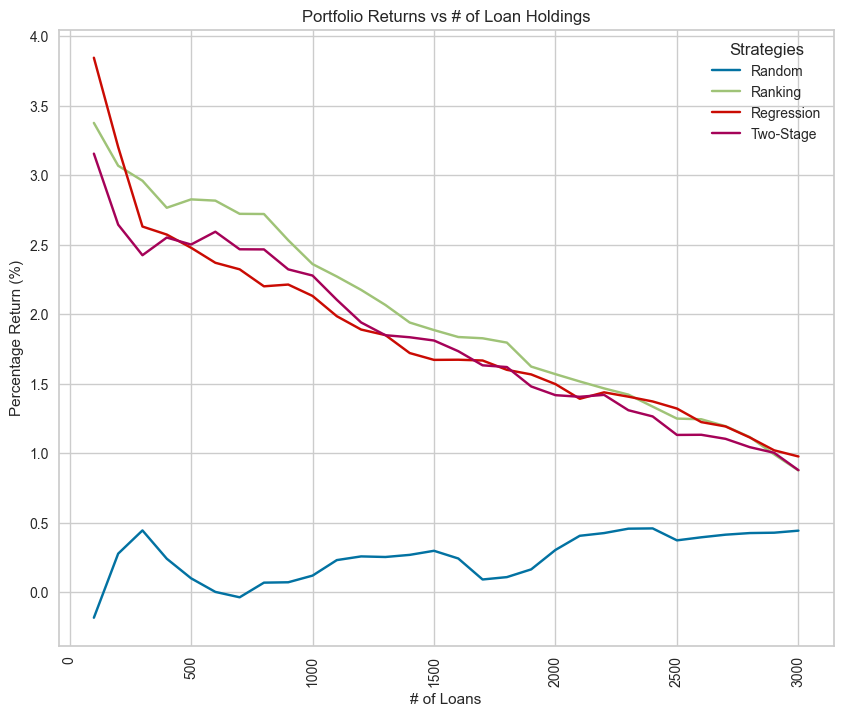

In [173]:
result_sensitivity_two_stage = []
result_sensitivity_random = []
result_sensitivity_ranking = []
result_sensitivity_regression = []
result_sensitivity_greedy = []
result_sensitivity_our_strategy = []

for strategy in strategies:

    if strategy == 'Two-stage':

        ## Vary the portfolio size from 100 to 1000
        for num_loans in list(range(100, 3100, 100)):
            reg_0 = test_investments(data_dict, 
                                    regressor=chosen_separated_regressor, 
                                    classifier=chosen_classifier, 
                                    strategy=strategy, 
                                    output_to_file=False,
                                    num_loans=num_loans)
            
            result_sensitivity_two_stage.append(reg_0['ret_INTb']['average return'])

    else:
        ## Vary the portfolio size from 100 to 1000
        for num_loans in list(range(100, 3100, 100)):
            reg_0 = test_investments(data_dict, 
                                    regressor=chosen_regressor, 
                                    classifier=chosen_classifier, 
                                    strategy=strategy,
                                    output_to_file=False, 
                                    num_loans=num_loans)

            if strategy == 'Random':
                result_sensitivity_random.append(reg_0['ret_INTb']['average return'])
            if strategy == 'Ranking':
                result_sensitivity_ranking.append(reg_0['ret_INTb']['average return'])
            if strategy == 'Regression':
                result_sensitivity_regression.append(reg_0['ret_INTb']['average return'])
            if strategy == 'Greedy':
                result_sensitivity_greedy.append(reg_0['ret_INTb']['average return'])
            if strategy == 'Our_Strategy':
                result_sensitivity_our_strategy.append(reg_0['ret_INTb']['average return'])

num_loans = list(range(100, 3100, 100))

loan_portfolio_df = pd.DataFrame({
    'Num_Loans':num_loans,
    'Random':result_sensitivity_random,
    'Ranking':result_sensitivity_ranking,
    'Regression':result_sensitivity_regression,
    'Two-Stage':result_sensitivity_two_stage,
    'Greedy':result_sensitivity_greedy,
    'Our_Strategy':result_sensitivity_our_strategy
})

loan_portfolio_df.set_index('Num_Loans', inplace=True)
loan_portfolio_df = loan_portfolio_df.loc[:, :] * 100

plt.figure(figsize=(10,8))
plt.plot(loan_portfolio_df.index, loan_portfolio_df['Random'], label='Random')
plt.plot(loan_portfolio_df.index, loan_portfolio_df['Ranking'], label='Ranking')
plt.plot(loan_portfolio_df.index, loan_portfolio_df['Regression'], label='Regression')
plt.plot(loan_portfolio_df.index, loan_portfolio_df['Two-Stage'], label='Two-Stage')
# plt.plot(loan_portfolio_df.index, loan_portfolio_df['Greedy'], label='Greedy')
# plt.plot(loan_portfolio_df.index, loan_portfolio_df['Our_Strategy'], label='Our_Strategy')
plt.title(f"Portfolio Returns vs # of Loan Holdings")
plt.ylabel('Percentage Return (%)')
plt.xlabel("# of Loans")
plt.xticks(rotation=90)
plt.legend(title='Strategies')
plt.show()

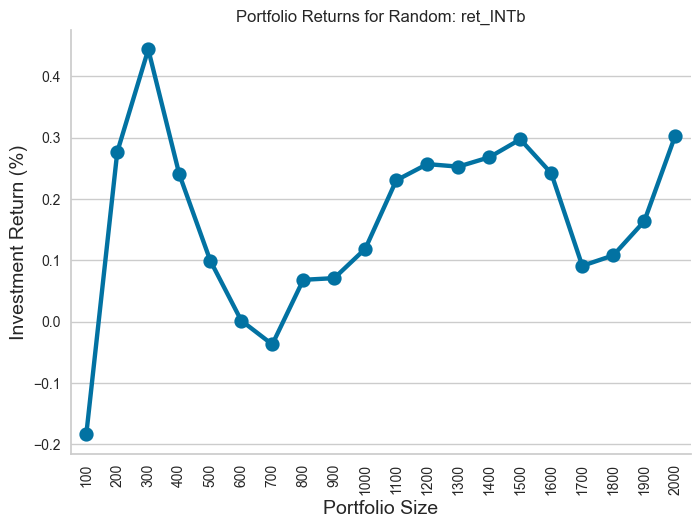

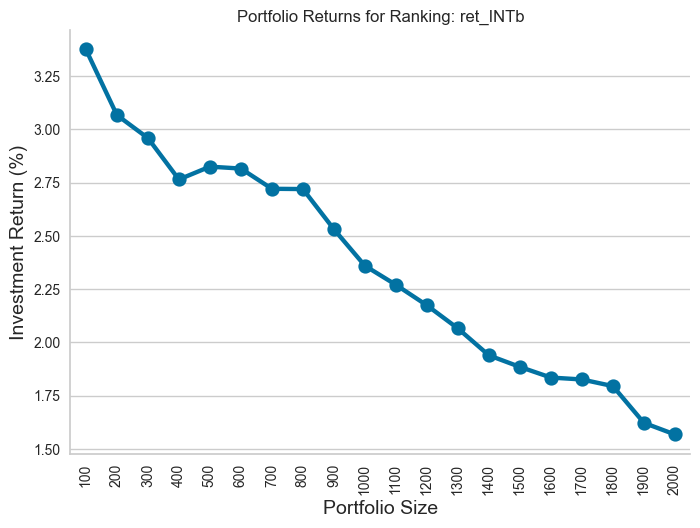

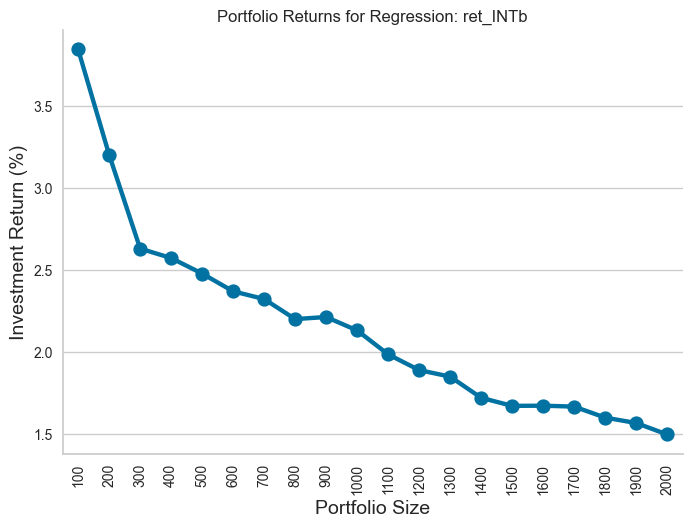

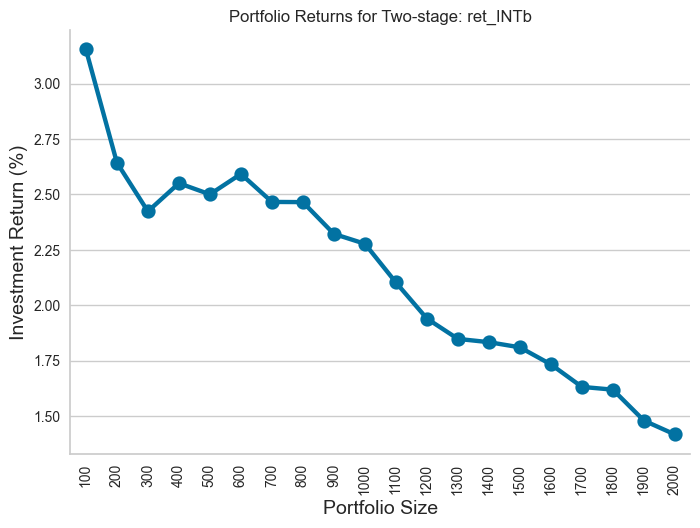

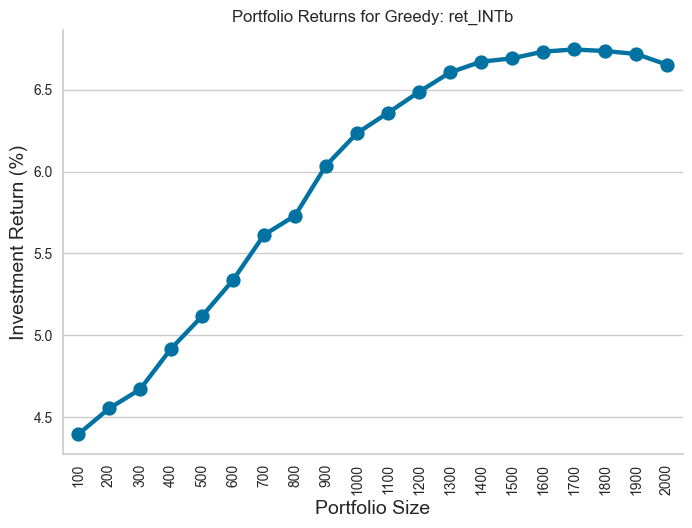

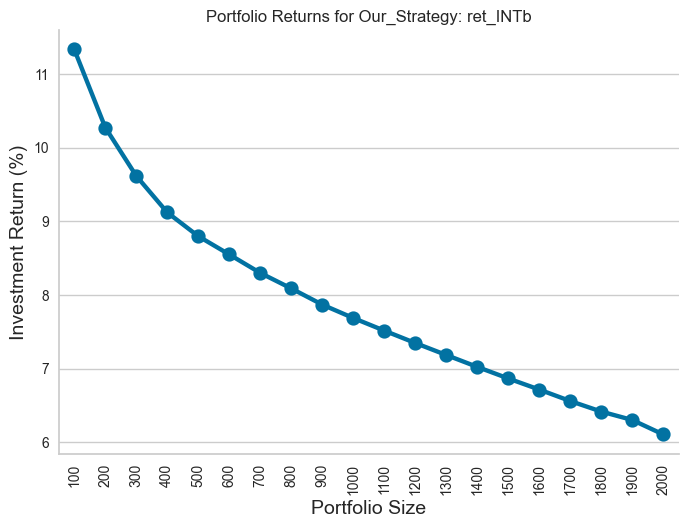

In [174]:
for strategy in strategies:

    if strategy == 'Two-stage':

        result_sensitivity = []

        ## Vary the portfolio size from 100 to 1000
        for num_loans in list(range(100,2100,100)):
            reg_0 = test_investments(data_dict, 
                                    regressor=chosen_separated_regressor, 
                                    classifier=chosen_classifier, 
                                    strategy=strategy, 
                                    output_to_file=False,
                                    num_loans=num_loans)
            
            result_sensitivity.append(reg_0['ret_INTb']['average return'])


        result_sensitivity = np.array(result_sensitivity) * 100
        sns.pointplot(x=np.array(list(range(100, 2100, 100))), y=result_sensitivity)
        sns.despine()
        plt.title(f"Portfolio Returns for {strategy}: ret_INTb")
        plt.ylabel('Investment Return (%)', size=14)
        plt.xlabel('Portfolio Size', size=14)
        plt.xticks(rotation=90)
        plt.show()  

    else:
        result_sensitivity = []

        ## Vary the portfolio size from 100 to 1000
        for num_loans in list(range(100,2100,100)):
            reg_0 = test_investments(data_dict, 
                                    regressor=chosen_regressor, 
                                    classifier=chosen_classifier, 
                                    strategy=strategy, 
                                    output_to_file=False,
                                    num_loans=num_loans)

            result_sensitivity.append(reg_0['ret_INTb']['average return'])


        result_sensitivity = np.array(result_sensitivity) * 100

        sns.pointplot(x=np.array(list(range(100, 2100, 100))), y=result_sensitivity)
        sns.despine()
        plt.title(f"Portfolio Returns for {strategy}: ret_INTb")
        plt.ylabel('Investment Return (%)', size=14)
        plt.xlabel('Portfolio Size', size=14)
        plt.xticks(rotation=90)
        plt.show()

# Optimization

 In this section, we implement three different optimization models. To illustrate and compare these models we will only use the INTb definition and the predicted returns from the previously tested "Our Strategy" strategy.

## Three optimization models to picks loans

### Directly maximize total profit

In [175]:
# Import docplex
import docplex
from docplex.mp.model import Model

In [176]:
ret_col = 'ret_INTb'
test_pool = two_stage[ret_col]['test data']
num_var = test_pool.shape[0]
num_loans = 100

# First define cost vector
c = np.zeros(num_var) # Cost vector
for i in range(num_var):
    c[i] = test_pool['predicted_return_'+ret_col].iloc[i] * test_pool.funded_amnt.iloc[i]
c = np.asarray(c)

# Create a new model
mdl = Model('Loan_Selection')

# Add decision variables
x = mdl.binary_var_list(num_var, name='x')

# Add constraint
mdl.add_constraint(mdl.sum(x[i] for i in range(num_var)) <= num_loans, 'UB on number of loans')

# Set objective
mdl.maximize(mdl.sum(x[i] * c[i] for i in range(num_var)))

# Solve the model and print the answer
mdl.solve()
opt_sln_IP1 = np.asarray(mdl.solution.get_values(x))
mdl.get_solve_details()
mdl.print_solution()

objective: 88485.265
status: OPTIMAL_SOLUTION(2)
  x_0=1
  x_1=1
  x_3=1
  x_5=1
  x_6=1
  x_13=1
  x_21=1
  x_25=1
  x_26=1
  x_31=1
  x_34=1
  x_42=1
  x_46=1
  x_52=1
  x_53=1
  x_56=1
  x_57=1
  x_59=1
  x_66=1
  x_68=1
  x_78=1
  x_82=1
  x_88=1
  x_90=1
  x_91=1
  x_105=1
  x_108=1
  x_118=1
  x_120=1
  x_122=1
  x_124=1
  x_127=1
  x_128=1
  x_131=1
  x_134=1
  x_135=1
  x_137=1
  x_147=1
  x_152=1
  x_154=1
  x_159=1
  x_167=1
  x_174=1
  x_178=1
  x_186=1
  x_191=1
  x_196=1
  x_203=1
  x_206=1
  x_212=1
  x_225=1
  x_233=1
  x_237=1
  x_240=1
  x_243=1
  x_252=1
  x_254=1
  x_268=1
  x_289=1
  x_292=1
  x_300=1
  x_314=1
  x_320=1
  x_330=1
  x_333=1
  x_347=1
  x_348=1
  x_352=1
  x_370=1
  x_373=1
  x_383=1
  x_385=1
  x_416=1
  x_418=1
  x_420=1
  x_448=1
  x_475=1
  x_487=1
  x_496=1
  x_515=1
  x_518=1
  x_536=1
  x_540=1
  x_548=1
  x_557=1
  x_569=1
  x_574=1
  x_584=1
  x_618=1
  x_644=1
  x_645=1
  x_652=1
  x_672=1
  x_682=1
  x_693=1
  x_709=1
  x_719=1
  x_723=1
 

### Partial Investments
Now we want to decide which loan to invest in, and how much should the investment be.

In [177]:
# Input variables
num_loans = 10
min_investment = 100

# Define cost vector
c = np.zeros(num_var)
for i in range(num_var):
    c[i] = test_pool['predicted_return_'+ret_col].iloc[i]

# Define vector of all ones
u = np.zeros(num_var)
for i in range(num_var):
    u[i] = 1

# Create a new model
mdl = Model('Loan_Selection_Partial')

# Add decision variables
x = mdl.binary_var_list(num_var, name='x')
y = mdl.continuous_var_list(num_var, ub=test_pool.funded_amnt.values, name='y')

# Add constraint
mdl.add_constraint(mdl.sum(x[i] for i in range(num_var)) <= num_loans, 'UB on number of loans')
for i in range(num_var):
    mdl.add_constraint(y[i] <= test_pool.funded_amnt.values[i] * x[i])

# Set objective
mdl.maximize(mdl.sum(c[i] * y[i] for i in range(num_var)))

# Solve the model and print the answer
mdl.solve()
mdl.get_solve_details()
mdl.print_solution()


objective: 11227.830
status: OPTIMAL_SOLUTION(2)
  x_3=1
  x_13=1
  x_25=1
  x_31=1
  x_34=1
  x_78=1
  x_91=1
  x_105=1
  x_118=1
  x_131=1
  y_3=28800.000
  y_13=35000.000
  y_25=35000.000
  y_31=35000.000
  y_34=35000.000
  y_78=35000.000
  y_91=35000.000
  y_105=35000.000
  y_118=35000.000
  y_131=35000.000


In [178]:
test_pool

,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,verification_status,issue_d,loan_status,...,ret_INTa,ret_INTb,ret_INTc,outcome,cr_hist,train,score,predicted_regular_return,predicted_default_return,predicted_return_ret_INTb
0,25000.0,25000.0,36,13.99,C,10,MORTGAGE,Not Verified,2015-09-01,Charged Off,...,-0.111023,-0.103561,-0.089730,True,566.548387,False,0.369812,0.085458,-0.040387,0.038919
1,25000.0,25000.0,60,8.18,B,10,MORTGAGE,Not Verified,2015-10-01,Charged Off,...,-0.059749,-0.050319,-0.033136,True,528.225806,False,0.158435,0.054452,-0.044536,0.038769
2,16800.0,16800.0,60,9.99,B,4,MORTGAGE,Source Verified,2015-08-01,Fully Paid,...,0.045983,0.064036,0.097121,False,394.645161,False,0.213117,0.058480,-0.040575,0.037370
3,28800.0,28800.0,60,17.57,D,8,MORTGAGE,Not Verified,2015-10-01,Charged Off,...,-0.052247,-0.041864,-0.022891,True,203.258065,False,0.428979,0.094049,-0.038292,0.037278
4,14000.0,14000.0,60,11.53,B,10,OWN,Source Verified,2015-10-01,Charged Off,...,-0.057240,-0.047533,-0.029832,True,328.903226,False,0.262256,0.063135,-0.037251,0.036808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781,35000.0,35000.0,60,27.88,G,4,RENT,Verified,2015-11-01,Charged Off,...,-0.133018,-0.127250,-0.116533,True,131.548387,False,0.840688,0.127464,-0.070299,-0.038793
3782,24950.0,24950.0,60,27.31,G,6,RENT,Verified,2015-12-01,Fully Paid,...,0.047832,0.069538,0.109942,False,110.967742,False,0.862738,0.125218,-0.064924,-0.038824
3783,6000.0,6000.0,36,26.77,G,8,RENT,Verified,2015-12-01,Fully Paid,...,0.104119,0.124091,0.160436,False,134.516129,False,0.835281,0.097039,-0.066814,-0.039824
3784,20400.0,20400.0,60,22.99,F,0,RENT,Source Verified,2015-08-01,Charged Off,...,-0.138498,-0.133273,-0.123579,True,106.032258,False,0.859144,0.119151,-0.074717,-0.047409


### Maximize profit with budget constraint

In [179]:
# Model Inputs
Budget = 1_000_000

mdl = Model(name='OptimizeLoans')

# Define variables
x = mdl.binary_var_list(num_var, name='x')

# Constraints
mdl.add_constraint(mdl.sum(x) <= 100, 'UB')
mdl.add_constraint(mdl.sum(x) >= 50, 'LB')
mdl.add_constraint(mdl.sum(x[i] * test_pool.iloc[i]['loan_amnt'] for i in range(num_var)) <= Budget, 'Budget')

# Objective
c = [test_pool.iloc[i]['predicted_return_'+ret_col] * test_pool.iloc[i]['funded_amnt'] for i in range(num_var)]
mdl.maximize(mdl.sum(x[i] * c[i] for i in range(num_var)))

# Solve the model
solution = mdl.solve()
print("OPT=", np.asarray(solution.get_values(x)))

opt_sln_IP2 = np.array(mdl.solution.get_values(x))
print("Number of one's:", np.count_nonzero(solution.get_values(x)))
mdl.print_solution()

OPT= [1. 1. 1. ... 0. 0. 0.]
Number of one's: 57
objective: 34306.943
status: OPTIMAL_SOLUTION(2)
  x_0=1
  x_1=1
  x_2=1
  x_3=1
  x_4=1
  x_5=1
  x_6=1
  x_7=1
  x_8=1
  x_9=1
  x_10=1
  x_11=1
  x_12=1
  x_13=1
  x_14=1
  x_15=1
  x_16=1
  x_17=1
  x_18=1
  x_19=1
  x_20=1
  x_21=1
  x_22=1
  x_23=1
  x_24=1
  x_25=1
  x_26=1
  x_27=1
  x_28=1
  x_29=1
  x_30=1
  x_31=1
  x_32=1
  x_33=1
  x_34=1
  x_35=1
  x_36=1
  x_37=1
  x_38=1
  x_39=1
  x_40=1
  x_41=1
  x_42=1
  x_43=1
  x_45=1
  x_46=1
  x_47=1
  x_48=1
  x_49=1
  x_50=1
  x_51=1
  x_52=1
  x_53=1
  x_54=1
  x_55=1
  x_56=1
  x_58=1


### Sanity check
Intuitively the optimal solution $x^*$ should sequentially choose the highest return loans. We compare $x^*$ with opt_sln below.

In [180]:
temp = np.sort(c)
temp = temp[::-1] # in descending order
cutoff = temp[100]
x = np.zeros(num_var)
for i in range(num_var):
    if cutoff<c[i]:
        x[i]=1
print("number of entries that differ:", int((x-opt_sln_IP2).sum()) )

number of entries that differ: 43


In [181]:
## First we need to train a clustering model to estimate the variance of return
n_clusters = 50
train_set = data_dict['train_set']
data_train = data.loc[train_set,:]

# Create a dataframe for testing, including the score
data_test = two_stage[ret_col]['test data']

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_dict['X_train'])
data_train['clusID'] = kmeans.predict(data_dict['X_train'])
data_test['clusID'] = kmeans.predict(data_dict['X_test'])
data_test['volatility'] = 0

for idx in range(n_clusters):
    std_clus = np.std(data_train[ret_col][data_train.clusID == idx])
    data_test.volatility[data_test.clusID == idx] = std_clus

## Specify the parameters of the optimization model
## beta: penalty factor on the risk
beta = 0.9

In [182]:
beta = 0.1

# Create an instance of a model
m = Model(name='Maximize_Return')

# Assuming test_pool and other necessary variables are defined
num_var = test_pool.shape[0]
Budget = 1000000

# Add binary variables
x_vars = m.binary_var_list(num_var, name='x')

# Add constraints
m.add_constraint(m.sum(x_vars) <= 100, 'UB')
m.add_constraint(m.sum(x_vars) >= 50, 'LB')
m.add_constraint(m.sum(x_vars[i] * test_pool['funded_amnt'].iloc[i] for i in range(num_var)) <= Budget, 'budget')

# Set the objective
objective = m.sum(x_vars[i] * (test_pool['predicted_return_' + ret_col].iloc[i] - beta * test_pool['volatility'].iloc[i]) * test_pool['loan_amnt'].iloc[i] for i in range(num_var))
m.maximize(objective)

# Solve the model
solution = m.solve()

# Print the solution
if solution:
    print(np.asarray(solution.get_values(x_vars)))
    # Find argmax
    max_value = max(solution.get_values(x_vars))
    argmax_opt = [i for i, v in enumerate(solution.get_values(x_vars)) if v == max_value]
    print("Number of one's:", len(argmax_opt))
else:
    print("No solution found")
    
opt_sln_IP3 = np.array(m.solution.get_values(x_vars))
m.print_solution()

[1. 1. 1. ... 0. 0. 0.]
Number of one's: 62
objective: 27673.820
status: OPTIMAL_SOLUTION(2)
  x_0=1
  x_1=1
  x_2=1
  x_3=1
  x_4=1
  x_5=1
  x_6=1
  x_7=1
  x_8=1
  x_9=1
  x_10=1
  x_11=1
  x_12=1
  x_13=1
  x_14=1
  x_15=1
  x_17=1
  x_18=1
  x_19=1
  x_20=1
  x_21=1
  x_22=1
  x_23=1
  x_24=1
  x_25=1
  x_26=1
  x_27=1
  x_28=1
  x_29=1
  x_30=1
  x_31=1
  x_32=1
  x_35=1
  x_36=1
  x_37=1
  x_39=1
  x_40=1
  x_41=1
  x_42=1
  x_43=1
  x_44=1
  x_51=1
  x_52=1
  x_54=1
  x_55=1
  x_58=1
  x_60=1
  x_62=1
  x_64=1
  x_68=1
  x_69=1
  x_70=1
  x_72=1
  x_75=1
  x_84=1
  x_85=1
  x_94=1
  x_102=1
  x_118=1
  x_119=1
  x_133=1
  x_135=1


### Visualization: violin plots for the expected returns of the above strategies

In [183]:
test_pool['label'] = ['test_pool']*test_pool.shape[0]

# we create a df for OPT of IP1
test_pool['chosen_IP1'] = opt_sln_IP1
df1 = test_pool[test_pool.chosen_IP1 == 1].copy() # df containing only rows chosen by IP1
test_pool = test_pool.drop(columns=['chosen_IP1']) # drop this columns in order to append
df1 = df1.drop(columns=['chosen_IP1']) # drop this columns in order to append
df1['label'] = ['IP1']*df1.shape[0]

# we create a df for OPT of IP2
test_pool['chosen_IP2'] = opt_sln_IP2
df2 = test_pool[test_pool.chosen_IP2 == 1].copy() # df containing only rows chosen by IP2
test_pool = test_pool.drop(columns=['chosen_IP2']) # drop this columns in order to append
df2 = df2.drop(columns=['chosen_IP2']) # drop this columns in order to append
df2['label'] = ['IP2']*df2.shape[0]

# create a df for OPT of IP3
test_pool['chosen_IP3'] = opt_sln_IP3
df3 = test_pool[test_pool.chosen_IP3 == 1].copy() # df containing only rows chosen by IP3
test_pool = test_pool.drop(columns=['chosen_IP3']) # drop this columns in order to append
df3 = df3.drop(columns=['chosen_IP3']) # drop this columns in order to append
df3['label'] = ['IP3']*df3.shape[0]

# concatenate the dataframes
df_big = pd.concat([test_pool, df1,df2,df3])

In [184]:
df_big['label'].value_counts()

label
test_pool    3786
IP1           100
IP3            62
IP2            57
Name: count, dtype: int64

Text(0, 0.5, 'ret_INTb')

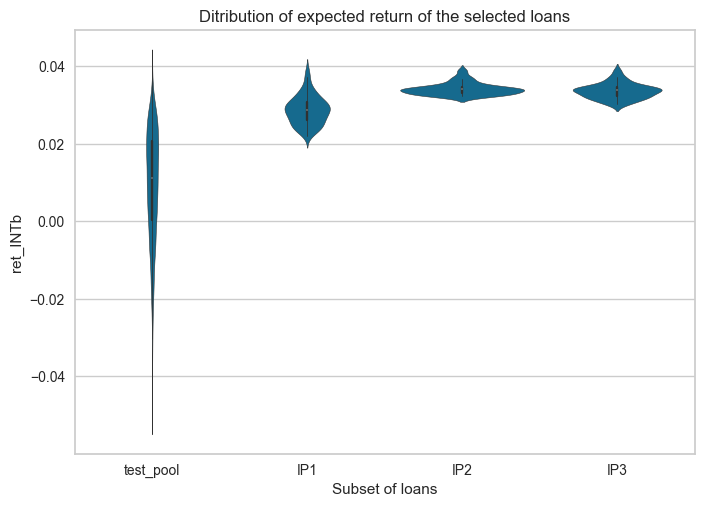

In [185]:
ax = sns.violinplot(y=df_big[f"predicted_return_{ret_col}"], x=df_big["label"], 
                    data=df_big, order=['test_pool','IP1','IP2','IP3'])
ax.set_title("Ditribution of expected return of the selected loans")
ax.set_xlabel("Subset of loans")
ax.set_ylabel(f"{ret_col}")

## Sensitivity analysis of the optimization solution by varying the budgets and the number of loans invested in
Build a trade-off curve between the beta value and the optimization objective (expected return). For this we loop through various values of beta from 0.1 through some large number in steps of 0.1 say. Then we create a plot of different pairs of means and stdevns of the expected return of the portfolios as you vary beta. The two axes will then be mean (return) and stdevn (risk).

In [186]:
# Assuming test_pool and other necessary variables are defined
num_var = test_pool.shape[0]
Budget = 1000000
beta_min = 0.1
step = 0.1
num_beta = 10
table = np.zeros([num_beta, 3])  # Store the return and risk
objective_values = []
selected_loans = []
total_investment = []
dfs = {}

for j in range(num_beta):
    beta = beta_min + j * step
    # Create a new model for each beta
    m = Model(name='Maximize_Return_with_Risk_Adjustment')

    # Add binary variables
    x_vars = m.binary_var_list(num_var, name='x')

    # Add constraints
    m.add_constraint(m.sum(x_vars) <= 100, 'UB')
    m.add_constraint(m.sum(x_vars) >= 50, 'LB')
    m.add_constraint(m.sum(x_vars[i] * test_pool['loan_amnt'].iloc[i] for i in range(num_var)) <= Budget, 'budget')

    # Set the objective
    objective = m.sum(x_vars[i] * 
                      (test_pool['predicted_return_' + ret_col].iloc[i] - beta * test_pool['volatility'].iloc[i]) * 
                       test_pool['loan_amnt'].iloc[i]
                       for i in range(num_var))
    m.maximize(objective)

    # Solve the model
    solution = m.solve(log_output=False)

    # Collect results
    if solution:
        test_pool['chosen'] = solution.get_values(x_vars)
        df = test_pool[test_pool.chosen == 1]
        table[j, 0] = beta
        table[j, 1] = df['predicted_return_' + ret_col].sum()
        table[j, 2] = df['volatility'].sum()

        # Add df to dictionary dfs
        dfs[beta] = df

        # Store the objective value
        objective_values.append(solution.objective_value)

        # Calculate the number of loans selected (sum of x_vars)
        num_loans_selected = sum(solution.get_values(x_vars))
        selected_loans.append(num_loans_selected)

        # Calculate the total investment taken
        total_invested = sum(test_pool['loan_amnt'].iloc[i] for i in range(num_var) if solution.get_value(x_vars[i]) == 1)
        total_investment.append(total_invested)
    else:
        print("No solution found for beta =", beta)   



Text(0, 0.5, 'risk')

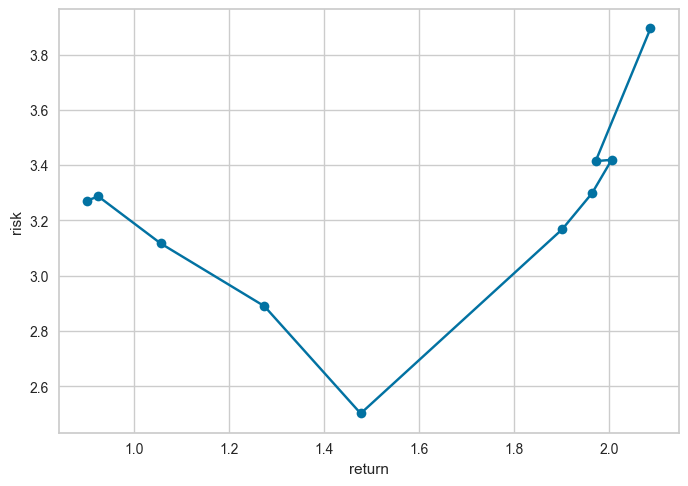

In [187]:
plt.plot(table[:,1],table[:,2], marker='o')
plt.xlabel("return")
plt.ylabel("risk")

In [188]:
risk_reward_df = pd.DataFrame({
    'Beta':table[:, 0],
    'Return':table[:, 1],
    'Standard_Deviation':table[:, 2]
})

In [189]:
# Add columns to the DataFrame for analysis
risk_reward_df['Risk_Adjusted_Return'] = risk_reward_df['Return'] / risk_reward_df['Standard_Deviation']
risk_reward_df['Dollars_Earned'] = objective_values
risk_reward_df['Number_of_Loans'] = selected_loans
risk_reward_df['Total_Investment'] = total_investment
risk_reward_df = risk_reward_df.sort_values('Risk_Adjusted_Return', ascending=False).reset_index(drop=True)

In [190]:
# The top row will provide the best risk-adjusted return
risk_reward_df

,Beta,Return,Standard_Deviation,Risk_Adjusted_Return,Dollars_Earned,Number_of_Loans,Total_Investment
0,0.5,1.901010,3.168258,0.600017,5235.048764,61.0,999500.0
1,0.4,1.963713,3.298419,0.595350,10496.920047,62.0,999400.0
2,0.6,1.476717,2.502330,0.590137,1002.982503,50.0,604775.0
3,0.3,2.005093,3.419382,0.586390,15943.302529,62.0,999975.0
4,0.2,1.971411,3.414549,0.577356,21626.391824,60.0,999975.0
5,0.1,2.086784,3.894194,0.535871,27673.820265,62.0,999950.0
6,0.7,1.274052,2.890108,0.440832,-1237.003029,50.0,344300.0
7,0.8,1.055631,3.117156,0.338652,-2450.560190,50.0,185150.0
8,0.9,0.924174,3.287405,0.281126,-3198.899218,50.0,100075.0
9,1.0,0.900255,3.271169,0.275209,-3803.312830,50.0,99275.0


Beta is the risk aversion parameter meaning that the higher this value, the more risk averse the investor and the lower this value, the more risk aggressive the investor. 

**Note**: It is important to note that being too aggressive hurts risk-adjusted returns and that being to risk averse also reduced risk-adjusted returns. It is important to find a balance and accept a level of risk when investing in a portfolio of P2P loans. 

In [191]:
# Analyze the model with the best risk-adjusted return
best_optimization_model = dfs[risk_reward_df.loc[0, 'Beta']].copy()

In [192]:
# Original data set to compare the different values
subset_df[['loan_amnt', 'int_rate', 'emp_length']].describe()

,loan_amnt,int_rate,emp_length
count,655157.000000,655157.000000,655157.000000
mean,15107.910165,13.015091,6.058333
std,8524.167013,4.355679,3.689146
min,1000.000000,5.320000,0.000000
25%,8450.000000,9.670000,3.000000
50%,13750.000000,12.690000,7.000000
75%,20000.000000,15.610000,10.000000
max,35000.000000,28.990000,10.000000


<Axes: xlabel='grade'>

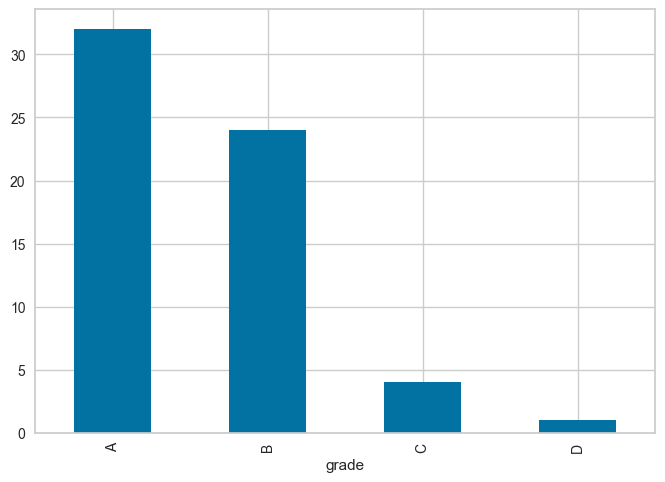

In [193]:
best_optimization_model['grade'].value_counts().plot(kind='bar')

In [194]:
# Summing total predicted and actual returns
model_predicted_returns = best_optimization_model['predicted_return_ret_INTb'].sum()
actual_returns = best_optimization_model['ret_INTb'].sum()

# Calculating the percentage difference between predicted and actual returns
percentage_diff = model_predicted_returns - actual_returns

# Print out the results
print(f"Total Predicted Returns: {model_predicted_returns}")
print(f"Total Actual Returns: {actual_returns}")
print(f"Total Model Error: {percentage_diff}")

Total Predicted Returns: 1.9010096993705845
Total Actual Returns: 1.7464332348895075
Total Model Error: 0.15457646448107698


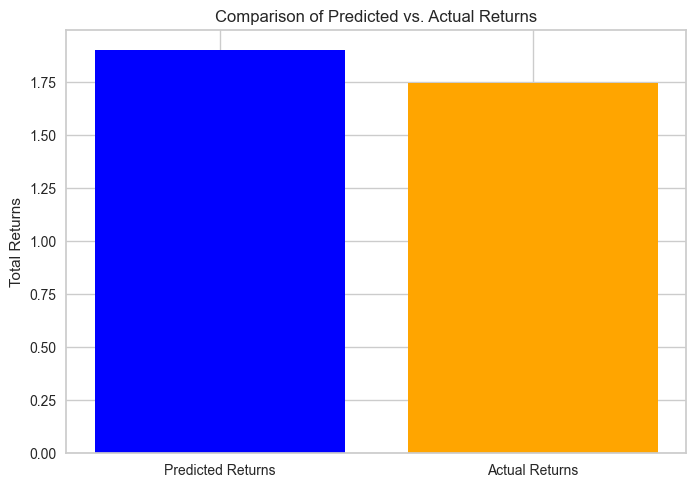

In [195]:
# Data for plotting
labels = ['Predicted Returns', 'Actual Returns']
values = [model_predicted_returns, actual_returns]

# Create a bar chart
plt.bar(labels, values, color=['blue', 'orange'])
plt.ylabel('Total Returns')
plt.title('Comparison of Predicted vs. Actual Returns')
plt.show()

The optimized risk-adjusted return portfolio using the L1 Penalized Logistic Regression classifer and the Random Forest regressor performed very well on the test data showing a very small error in prediction versus actual results. 

This builds confidence in developing a loan portfolio using these models deployed in the future.